### SDV Introduction

`Synthetic Data Vault (SDV)` is an ecosystem of libraries   that allows users to easily learn single-table, multi-table and time-series datasets to later on generate new synthetic data that has the same format and statistical properties as the original dataset.

For a multi-table table data scenario, the SDV provides the HMA1 Model (based on copula funtions). The  sdv.relational.HMA1 class implements what is called a Hierarchical Modeling Algorithm which is an algorithm that allows to recursively walk through a relational dataset and apply tabular models across all the tables in a way that lets the models learn how all the fields from all the tables are related. (https://sdv.dev/SDV/user_guides/relational/hma1.html)

`Furthermore, SDV models allow us to set a primary key of the table as well as some advanced usages including:`

 - Anonymizing Personally Identifiable Information (PII)
 - Setting Bounds and Specifying Rounding for Numerical Columns
 - Setting Distributions for Individual Variables
 - Conditional Sampling
 - Other Customizable Constraints and Evaluation Options 
 
According to the user guide, there are still other models for the single-table and time-series data scenarios. However, I will focus my article on the  multi-table data for now.

### Dataset Background


The dataset is a subset of the National Pasient Register dataset (NPR), anonymised and transformed for the purpose of synthetising .
The dataset is a relational model of the following entityes
 - patient (pasient)
 - referals (henvisningsperiode)
 - stays (episode)
 
 The dataset contains a good mix of features categorical,  numerical and primary key . Below i a short description of the columns:
 - patient: 
    - patientNr: primary key
    - ageGrp (ageGrpup: 1: 0-9,2:10-19,...)
    - sex (0: women, 1: men)
 - referral
    - referalID: primary key
    - patientNr: foreign key to patient
    - referalDate: Creation Date of the referals
    - referal_length: length of referals (enddate of the referals - ansiendato)
    - MainDiagGrp: Grouped Main diagnosis of the last stay
 - Stays 
    - stayID: primary key
    - referalID: foreign key  to referal
    - stayDate:  Date of the stay
    - stay_length: length of stay (enddate of the stay - innDatoTid)
    - polUtforendeGrp: grouped medical personnel
    - kontaktTypeGrp: grouped stayType
    - spesialist
    - rolleGrp: grouped rolle
    - MainDiagGrp: Grouped Main diagnosis 

### Code Implementation

In [1]:
import sdv
print(sdv.__version__)

1.10.0


In [2]:
#import sweetviz as sv
import pandas as pd
#import dtale
import numpy as np

%matplotlib inline


import os
import json

#from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
#import umap.plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

from functions import condense_category#,cluster_profile

from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score
import seaborn as sns
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore')    
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.set_option('display.max_columns', None)
from sdv.metadata import MultiTableMetadata
#from sdv import Metadata
from sdv.multi_table import HMASynthesizer
#from sdv.relational import HMA1
from sklearn.metrics import silhouette_samples , silhouette_score
import matplotlib.cm as cm
from kmodes.kmodes import KModes
from kmodes import kprototypes
from sklearn.metrics import silhouette_score

import logging
logging.getLogger('matplotlib.font_manager').disabled = True



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Read the datasets

We start by  importing  the the patient, referal and stay entities. The data imported is beforehand  transformed and anonymised.

In [3]:
stay_features =['referralID', 'stayID'#,'stayOrder'
                ,'stayStartDate','stayEndDate',
       'stayLength',# 'ReshID_Avdeling', 'ReshID_Seksjon',
       'personnelGrp',  'stayTypeGrp','specialist',
       'roleGrp','cond1axis1Grp', 'cond1axis2Grp', 'cond1axis3Grp',
       'cond1axis4Grp', 'cond1axis5Grp','cond1axis6Grp'

]


df_stays = pd.read_csv("../../data/processed/stays_transformed.csv",sep='\t'  
                    ,parse_dates=['stayStartDate','stayEndDate']
                       ,  dtype=
                 
                 { 'referralID':'int'
, 'stayID' : 'int'        

            


  
                     


                 },usecols =stay_features
  )

df_stays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73134 entries, 0 to 73133
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   referralID     73134 non-null  int64         
 1   stayID         73134 non-null  int64         
 2   stayStartDate  73134 non-null  datetime64[ns]
 3   stayEndDate    73134 non-null  datetime64[ns]
 4   stayLength     73134 non-null  int64         
 5   personnelGrp   73134 non-null  object        
 6   stayTypeGrp    73134 non-null  object        
 7   specialist     73134 non-null  object        
 8   roleGrp        73134 non-null  object        
 9   cond1axis1Grp  73134 non-null  object        
 10  cond1axis2Grp  73134 non-null  object        
 11  cond1axis3Grp  73134 non-null  object        
 12  cond1axis4Grp  73134 non-null  object        
 13  cond1axis5Grp  73134 non-null  object        
 14  cond1axis6Grp  73134 non-null  object        
dtypes: datetime64[ns](2

In [4]:
#df_stays.cond1axis6Grp.value_counts().plot(kind='barh')

In [5]:

referal_col =['referralID'  ,'patientNr'
          ,'referralStartDate','referralLength','referralEndDate'
              ,'numOfStays'
               , 'cond1axis1GrpLast','cond1axis1GrpFirst'
            
#, 'henvFraInstitusjonID'MainDiagGroup
          ]


df_referrals = pd.read_csv("../../data/processed/referrals_transformed.csv",sep='\t' ,parse_dates=['referralStartDate','referralEndDate']
  ,dtype=
                 
                 {
   
 'referralID': 'int',
 'patientNr'  : 'int'                 
  
                 }
                                    ,usecols =referal_col
                                   )


df_referrals.info()     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7730 entries, 0 to 7729
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          7730 non-null   int64         
 1   patientNr           7730 non-null   int64         
 2   referralStartDate   7730 non-null   datetime64[ns]
 3   referralEndDate     7730 non-null   datetime64[ns]
 4   referralLength      7730 non-null   int64         
 5   numOfStays          7730 non-null   int64         
 6   cond1axis1GrpLast   7730 non-null   object        
 7   cond1axis1GrpFirst  7730 non-null   object        
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 483.2+ KB


In [6]:
df_referrals.head()

,referralID,patientNr,referralStartDate,referralEndDate,referralLength,numOfStays,cond1axis1GrpLast,cond1axis1GrpFirst
0,558570,123646,2011-11-17,2016-06-07,1664,3,1999,1999
1,59513,167528,2011-11-25,2015-06-24,1307,1,F90-F98,F90-F98
2,687483,630339,2011-11-30,2018-01-04,2227,1,F90-F98,F90-F98
3,162928,244546,2011-12-08,2017-06-20,2021,1,F90-F98,F90-F98
4,901164,545086,2011-12-12,2015-01-28,1143,1,F90-F98,F90-F98


In [7]:
patient_col =['patientNr'
          ,'sex','age','ageGrp','ageGrpDesc'
          ]
df_patients = pd.read_csv("../../data/processed/patients_transformed.csv",sep='\t',usecols =patient_col)

df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6924 entries, 0 to 6923
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patientNr   6924 non-null   int64 
 1   ageGrp      6924 non-null   int64 
 2   ageGrpDesc  6924 non-null   object
 3   sex         6924 non-null   int64 
 4   age         6924 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 270.6+ KB


<Axes: xlabel='ageGrpDesc'>

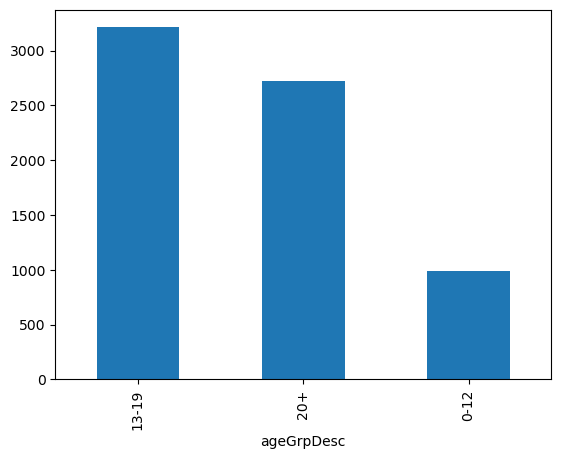

In [8]:
df_patients['ageGrpDesc'].value_counts().plot(kind='bar')

In [9]:
len(df_referrals['referralID'].unique())

7730

In [10]:
len(df_stays['referralID'].unique())

7730

In [11]:
len(df_referrals['patientNr'].unique())

6924

In [12]:
len(df_patients['patientNr'].unique())

6924

In [13]:
df_referrals_t= df_referrals.copy()
df_stays_t =df_stays.copy()
df_patients_t =df_patients.copy()

In [14]:
#df_referrals_t = df_referrals_t[~df_referrals_t.cond1axis1GrpFirst.isin(['Z00-Z13','R40-R46','1999'])]
#df_referrals_t = df_referrals_t[~df_referrals_t.cond1axis1GrpLast.isin(['Z00-Z13','R40-R46','1999'])]
df_referrals_t.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7730 entries, 0 to 7729
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          7730 non-null   int64         
 1   patientNr           7730 non-null   int64         
 2   referralStartDate   7730 non-null   datetime64[ns]
 3   referralEndDate     7730 non-null   datetime64[ns]
 4   referralLength      7730 non-null   int64         
 5   numOfStays          7730 non-null   int64         
 6   cond1axis1GrpLast   7730 non-null   object        
 7   cond1axis1GrpFirst  7730 non-null   object        
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 483.2+ KB


In [15]:
#df_patients_t = df_patients_t.sample(5000)
#df_patients_t.info()

In [16]:
df_referrals_t =df_referrals_t[ df_referrals_t['patientNr'].isin(df_patients_t['patientNr'].unique())]
df_referrals_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7730 entries, 0 to 7729
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          7730 non-null   int64         
 1   patientNr           7730 non-null   int64         
 2   referralStartDate   7730 non-null   datetime64[ns]
 3   referralEndDate     7730 non-null   datetime64[ns]
 4   referralLength      7730 non-null   int64         
 5   numOfStays          7730 non-null   int64         
 6   cond1axis1GrpLast   7730 non-null   object        
 7   cond1axis1GrpFirst  7730 non-null   object        
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 483.2+ KB


In [17]:
df_stays_real =df_stays_t[ df_stays_t['referralID'].isin(df_referrals_t['referralID'].unique())]
df_stays_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73134 entries, 0 to 73133
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   referralID     73134 non-null  int64         
 1   stayID         73134 non-null  int64         
 2   stayStartDate  73134 non-null  datetime64[ns]
 3   stayEndDate    73134 non-null  datetime64[ns]
 4   stayLength     73134 non-null  int64         
 5   personnelGrp   73134 non-null  object        
 6   stayTypeGrp    73134 non-null  object        
 7   specialist     73134 non-null  object        
 8   roleGrp        73134 non-null  object        
 9   cond1axis1Grp  73134 non-null  object        
 10  cond1axis2Grp  73134 non-null  object        
 11  cond1axis3Grp  73134 non-null  object        
 12  cond1axis4Grp  73134 non-null  object        
 13  cond1axis5Grp  73134 non-null  object        
 14  cond1axis6Grp  73134 non-null  object        
dtypes: datetime64[ns](2

In [18]:
df_referrals_real = pd.merge(df_referrals_t ,df_patients_t, on=['patientNr'])
df_referrals_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7730 entries, 0 to 7729
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          7730 non-null   int64         
 1   patientNr           7730 non-null   int64         
 2   referralStartDate   7730 non-null   datetime64[ns]
 3   referralEndDate     7730 non-null   datetime64[ns]
 4   referralLength      7730 non-null   int64         
 5   numOfStays          7730 non-null   int64         
 6   cond1axis1GrpLast   7730 non-null   object        
 7   cond1axis1GrpFirst  7730 non-null   object        
 8   ageGrp              7730 non-null   int64         
 9   ageGrpDesc          7730 non-null   object        
 10  sex                 7730 non-null   int64         
 11  age                 7730 non-null   int64         
dtypes: datetime64[ns](2), int64(7), object(3)
memory usage: 724.8+ KB


In [19]:
len(df_stays_real['referralID'].unique())

7730

In [20]:
len(df_referrals_real['referralID'].unique())

7730

### Select the features to synthetise

In [21]:
referral_features = [ 'referralID','referralStartDate','referralLength','age','sex'
                    
   #  , 'referralEndDate'
                   ]
df_referrals_r= df_referrals_real[referral_features]

df_referrals_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7730 entries, 0 to 7729
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   referralID         7730 non-null   int64         
 1   referralStartDate  7730 non-null   datetime64[ns]
 2   referralLength     7730 non-null   int64         
 3   age                7730 non-null   int64         
 4   sex                7730 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 302.1 KB


In [22]:
stay_features =['referralID', 'stayID' ,'stayStartDate'#'stayOrder'#, 'stayEndDate'
       ,'stayLength'#', 'ReshID_Avdeling', 'ReshID_Seksjon',
       ,'personnelGrp',  'stayTypeGrp','specialist',
       'roleGrp','cond1axis1Grp', 'cond1axis2Grp', 'cond1axis3Grp',
       'cond1axis4Grp', 'cond1axis5Grp','cond1axis6Grp'

              #  , 'cond5axis1Grp',      'cond6axis1Grp'
                   #, 'tilst2akse1Grp','tilst3akse1Grp' ,'tilst4akse1Grp' ,'tilst5akse1Grp' ,'tilst6akse1Grp' 

]

df_stays_r= df_stays_real[stay_features]
df_stays_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73134 entries, 0 to 73133
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   referralID     73134 non-null  int64         
 1   stayID         73134 non-null  int64         
 2   stayStartDate  73134 non-null  datetime64[ns]
 3   stayLength     73134 non-null  int64         
 4   personnelGrp   73134 non-null  object        
 5   stayTypeGrp    73134 non-null  object        
 6   specialist     73134 non-null  object        
 7   roleGrp        73134 non-null  object        
 8   cond1axis1Grp  73134 non-null  object        
 9   cond1axis2Grp  73134 non-null  object        
 10  cond1axis3Grp  73134 non-null  object        
 11  cond1axis4Grp  73134 non-null  object        
 12  cond1axis5Grp  73134 non-null  object        
 13  cond1axis6Grp  73134 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(10)
memory usage: 7.8+ MB


In [23]:

#real_data ={'stay':df_stays_real,'referral':df_referrals_real,'patient':df_patients_real}
real_data ={'stay':df_stays_r,'referral':df_referrals_r}

In [24]:

ids = df_referrals_r["referralID"]
df_referrals_r[ids.isin(ids[ids.duplicated()])].sort_values("referralID")

,referralID,referralStartDate,referralLength,age,sex


### Build the metadata object for the dataset


In [25]:
#https://sdv.dev/SDV/user_guides/relational/hma1.html

In SDV, the structure of a dataset is represented using the class sdv.Metadata, which contains all the information that SDV needs in order to optimally learn the dataset and generate synthetic versions of it. We created a json file metadata_simple.json with all the information that SDV needs to know about the dataset and progmatically added som extra variables to one of the classes (stays). 

In [26]:
from sdv.metadata import MultiTableMetadata
metadata = MultiTableMetadata()
metadata.detect_from_dataframes(
    data=real_data
)


In [27]:
metadata.validate()

In [28]:
metadata.validate_data(data=real_data)

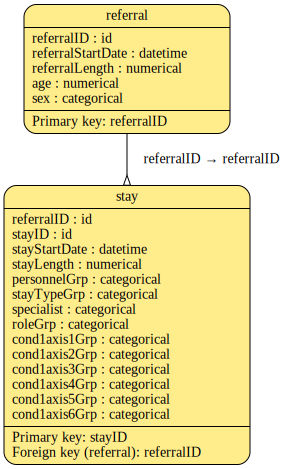

In [29]:
metadata.visualize(
    show_table_details='full',
    show_relationship_labels=True#,
    #output_filepath='my_metadata.png'
)

For more details about how to build the Metadata ,  refer to the Relational Metadata Guide.https://sdv.dev/SDV/user_guides/relational/relational_metadata.html#relational-metadata

### Build the HMA1 Synthetic model


`We use now the HMA1 class to learn the real data.` The output model will be used to  sample synthetic data about new referals/patients/stays, we proceed by:

 - Import the sdv.relational.HMA1 class and create an instance of it passing the metadata that we just loaded.

 - Call its fit method passing the tables dict.

In [440]:
#my_model_kwargs ={'default_distribution': 'gaussian','categorical_transformer':'LabelEncoder'}
#model = HMA1(metadata=metadata,model_kwargs=my_model_kwargs)
synthesizer = HMASynthesizer(metadata)

#synthesizer.auto_assign_transformers(real_data)

/opt/miniconda3/envs/sdv_env/lib/python3.10/site-packages/sdv/multi_table/base.py:75: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [441]:
synthesizer.fit(real_data)


Preprocess Tables: 100%|██████████| 2/2 [00:05<00:00,  2.54s/it]



Learning relationships:


(1/1) Tables 'referral' and 'stay' ('referralID'):  34%|███▍      | 1914/5649 [13:51<20:13,  3.08it/s]

In [ ]:

synthesizer.set_table_parameters(
    table_name='stay',
    #table_synthesizer='GaussianCopulaSynthesizer',
    table_parameters={
        'enforce_min_max_values': True,
         'default_distribution': 'truncnorm',
          'numerical_distributions': { 
            'stayLength': 'norm',
           'stayStartDate': 'uniform' 
         
            
        }
   
         
     
    }
)

synthesizer.set_table_parameters(
    table_name='referral',
    #table_synthesizer='GaussianCopulaSynthesizer',
    table_parameters={
        'enforce_min_max_values': True,
        'default_distribution': 'truncnorm',
        'numerical_distributions': { 
            'referralLength': 'norm',
            'age': 'norm',
            'sex': 'norm',
        'referralStartDate': 'uniform' 
         
            
        }
    }
)

synthesizer.fit(real_data)


Preprocess Tables: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]



Learning relationships:


(1/1) Tables 'referral' and 'stay' ('referralID'):   1%|          | 20/2321 [00:00<01:03, 36.22it/s]invalid value encountered in scalar divide
divide by zero encountered in scalar divide
(1/1) Tables 'referral' and 'stay' ('referralID'):   1%|          | 24/2321 [00:00<01:06, 34.52it/s]invalid value encountered in scalar divide
divide by zero encountered in scalar divide
(1/1) Tables 'referral' and 'stay' ('referralID'):   1%|▏         | 30/2321 [00:00<00:56, 40.68it/s]invalid value encountered in scalar divide
divide by zero encountered in scalar divide
(1/1) Tables 'referral' and 'stay' ('referralID'):   2%|▏         | 35/2321 [00:00<01:00, 37.93it/s]divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
(1/1) Tables 'referral' and 'stay' ('referralID'):   2%|▏         | 39/2321 [00:01<01:02, 36.63it/s]divide by zero encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide
divide by zero encoun

Modeling Tables: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


In [ ]:
synthesizer.save('../../models/synthetiser.pkl')
#synthesizer.save('../../models/latest.pkl')

In [38]:

synthesizer = HMASynthesizer.load('../../models/synthetiser.pkl')


In [221]:

synthesizer.get_transformers(table_name='referral')

{'referralID': IDGenerator(),
 'referralStartDate': UnixTimestampEncoder(datetime_format='%Y-%m-%d', enforce_min_max_values=True),
 'referralLength': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'age': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'sex': UniformEncoder()}

In [222]:

synthesizer.get_transformers(table_name='stay')

{'referralID': None,
 'stayID': IDGenerator(),
 'stayStartDate': UnixTimestampEncoder(datetime_format='%Y-%m-%d %H:%M:%S', enforce_min_max_values=True),
 'stayLength': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'personnelGrp': UniformEncoder(),
 'stayTypeGrp': UniformEncoder(),
 'specialist': UniformEncoder(),
 'roleGrp': UniformEncoder(),
 'cond1axis1Grp': UniformEncoder(),
 'cond1axis2Grp': UniformEncoder(),
 'cond1axis3Grp': UniformEncoder(),
 'cond1axis4Grp': UniformEncoder(),
 'cond1axis5Grp': UniformEncoder(),
 'cond1axis6Grp': UniformEncoder()}

we generate new data by calling the sample function

In [ ]:
#synthesizer.reset_sampling()
synthetic_data = synthesizer.sample(scale=1) 


There are null values in the transformed data. The reversed transformed data will contain null values.
There are null values in the transformed data. The reversed transformed data will contain null values.
There are null values in the transformed data. The reversed transformed data will contain null values.
There are null values in the transformed data. The reversed transformed data will contain null values.
There are null values in the transformed data. The reversed transformed data will contain null values.
There are null values in the transformed data. The reversed transformed data will contain null values.
There are null values in the transformed data. The reversed transformed data will contain null values.
There are null values in the transformed data. The reversed transformed data will contain null values.
There are null values in the transformed data. The reversed transformed data will contain null values.
There are null values in the transformed data. The reversed transformed d


we store the synthetic data into the dataframes for evaluation

In [359]:
df_referrals_synthetic= synthetic_data['referral']
df_stays_synthetic= synthetic_data['stay']
#df_patients_synthetic= synthetic_data['patient']

In [360]:
df_referrals_synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   referralID         2321 non-null   int64         
 1   referralStartDate  2321 non-null   datetime64[ns]
 2   referralLength     2321 non-null   int64         
 3   age                2321 non-null   int64         
 4   sex                2321 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 90.8 KB


In [361]:
df_stays_synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   referralID     26179 non-null  int64         
 1   stayID         26179 non-null  int64         
 2   stayStartDate  26179 non-null  datetime64[ns]
 3   stayLength     26179 non-null  int64         
 4   personnelGrp   26174 non-null  object        
 5   stayTypeGrp    26179 non-null  object        
 6   specialist     26115 non-null  object        
 7   roleGrp        25966 non-null  object        
 8   cond1axis1Grp  26179 non-null  object        
 9   cond1axis2Grp  26170 non-null  object        
 10  cond1axis3Grp  26163 non-null  object        
 11  cond1axis4Grp  26113 non-null  object        
 12  cond1axis5Grp  26175 non-null  object        
 13  cond1axis6Grp  26148 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(10)
memory usage: 2.8+ MB


In [49]:


df_referrals_synthetic.to_csv("../../data/synthetic/referrals_synthetic.csv", sep='\t',index=False)


In [30]:



df_referrals_synthetic = pd.read_csv("../../data/synthetic/referrals_synthetic.csv",sep='\t'
                           ,parse_dates=['referralStartDate']
  ,dtype=
                 
                 {
   
 'referralID': 'int',
 'patientNr'  : 'int'                 
  
                 }
                                    
                                   )


df_referrals_synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   referralID         5569 non-null   int64         
 1   referralStartDate  5569 non-null   datetime64[ns]
 2   referralLength     5569 non-null   int64         
 3   age                5569 non-null   int64         
 4   sex                5569 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 217.7 KB


In [51]:


df_stays_synthetic.to_csv("../../data/synthetic/stays_synthetic.csv", sep='\t',index=False)


In [31]:

df_stays_synthetic = pd.read_csv("../../data/synthetic/stays_synthetic.csv",sep='\t'  
                    ,parse_dates=['stayStartDate']
                       ,  dtype=
                 
                 { 'referralID':'int'
, 'stayID' : 'int'        

            


  
                     


                 }
  )
df_stays_synthetic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55784 entries, 0 to 55783
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   referralID     55784 non-null  int64         
 1   stayID         55784 non-null  int64         
 2   stayStartDate  26822 non-null  datetime64[ns]
 3   stayLength     55784 non-null  int64         
 4   personnelGrp   55784 non-null  object        
 5   stayTypeGrp    55784 non-null  object        
 6   specialist     55784 non-null  object        
 7   roleGrp        55784 non-null  object        
 8   cond1axis1Grp  55784 non-null  object        
 9   cond1axis2Grp  55784 non-null  object        
 10  cond1axis3Grp  55784 non-null  object        
 11  cond1axis4Grp  55784 non-null  object        
 12  cond1axis5Grp  55784 non-null  object        
 13  cond1axis6Grp  55784 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(10)
memory usage: 6.0+ MB


In [32]:
#synthetic_data_t ={'stay':df_stays_synth,'referral':df_referrals_synth,'patient':df_patients_synth}
synthetic_data ={'stay':df_stays_synthetic,'referral':df_referrals_synthetic}

### Check number of orphans patient--> referal-->stay

In [33]:
referallist=df_stays_synthetic.referralID.unique().tolist()
referalliststay=df_referrals_synthetic.referralID.unique().tolist()
diff =list(set(referallist) - set(referalliststay))
len(diff)

0

### Evaluate the HMA1 synthetic Model

### Quality/Diagnostics Report

In [145]:
from sdv.evaluation.multi_table import evaluate_quality
quality_report = evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata)

Generating report ...
(4/4) Evaluating Intertable Trends: : 100%|██████████| 70/70 [00:02<00:00, 27.62it/s] 

Overall Score: 68.49%

Properties:
- Column Shapes: 75.21%
- Column Pair Trends: 64.66%
- Cardinality: 84.61%
- Intertable Trends: 49.49%


In [146]:
from sdv.evaluation.multi_table import run_diagnostic

diagnostic_report = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...
(3/3) Evaluating Relationship Validity: : 100%|██████████| 1/1 [00:00<00:00, 133.87it/s]

Overall Score: 98.17%

Properties:
- Data Validity: 94.51%
- Data Structure: 100.0%
- Relationship Validity: 100.0%


### Detail- report

In [147]:

quality_report.get_details(property_name='Column Shapes', table_name='referral')

,Table,Column,Metric,Score
12,referral,referralStartDate,KSComplement,0.000259
13,referral,referralLength,KSComplement,0.912671
14,referral,age,KSComplement,0.937566
15,referral,sex,TVComplement,0.994239


In [148]:
quality_report.get_details(property_name='Column Shapes', table_name='stay')

,Table,Column,Metric,Score
0,stay,stayStartDate,KSComplement,0.442174
1,stay,stayLength,KSComplement,0.462198
2,stay,personnelGrp,TVComplement,0.805055
3,stay,stayTypeGrp,TVComplement,0.888217
4,stay,specialist,TVComplement,0.668259
5,stay,roleGrp,TVComplement,0.668707
6,stay,cond1axis1Grp,TVComplement,0.868674
7,stay,cond1axis2Grp,TVComplement,0.929098
8,stay,cond1axis3Grp,TVComplement,0.854204
9,stay,cond1axis4Grp,TVComplement,0.905781


## Anonimity

In [144]:
import matplotlib.pyplot as plt
#import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

In [145]:
columns =[ 'stayLength', 'stayStartDate', 'personnelGrp',
       'stayTypeGrp', 'specialist', 'roleGrp', 'cond1axis1Grp',
       'cond1axis2Grp', 'cond1axis3Grp', 'cond1axis4Grp', 'cond1axis5Grp',
       'cond1axis6Grp', 'age', 'sex', 'referralLength', 'referralStartDate']
ori=pd.merge(df_stays_real,df_referrals_real,on=['referralID'])
ori = ori[columns]

In [146]:
columns =[ 'stayLength', 'stayStartDate', 'personnelGrp',
       'stayTypeGrp', 'specialist', 'roleGrp', 'cond1axis1Grp',
       'cond1axis2Grp', 'cond1axis3Grp', 'cond1axis4Grp', 'cond1axis5Grp',
       'cond1axis6Grp', 'age', 'sex', 'referralLength', 'referralStartDate']
syn=pd.merge(df_stays_synthetic,df_referrals_synthetic,on=['referralID'])
syn = syn[columns]

In [175]:
df_ref = df_referrals_real.sample(2500)
df_sta =df_stays_t[ df_stays_t['referralID'].isin(df_ref['referralID'].unique())]
control=pd.merge(df_sta,df_ref,on=['referralID'])

control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24319 entries, 0 to 24318
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   referralID         24319 non-null  int64         
 1   stayID             24319 non-null  int64         
 2   stayStartDate      24319 non-null  datetime64[ns]
 3   stayEndDate        24319 non-null  datetime64[ns]
 4   stayLength         24319 non-null  int64         
 5   personnelGrp       24319 non-null  object        
 6   stayTypeGrp        24319 non-null  object        
 7   specialist         24319 non-null  object        
 8   roleGrp            24319 non-null  object        
 9   cond1axis1Grp      24319 non-null  object        
 10  cond1axis2Grp      24319 non-null  object        
 11  cond1axis3Grp      24319 non-null  object        
 12  cond1axis4Grp      24319 non-null  object        
 13  cond1axis5Grp      24319 non-null  object        
 14  cond1a

### Measuring the singling out risk

The `SinglingOutEvaluator` try to measure how much the synthetic data can help an attacker finding combination of attributes that single out records in the training data. 

With the following code we evaluate the robustness of the synthetic data to "univariate" singling out attacks, which try to find unique values of some attribute which single out an individual. 


##### NOTE:

The `SingingOutEvaluator` can sometimes raise a `RuntimeError`. This happens when not enough singling out queries are found. Increasing `n_attacks` will make this condition less frequent and the evaluation more robust, although much slower.

In [148]:
evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=1000)

try:
    evaluator.evaluate(mode='univariate')
    risk = evaluator.risk(confidence_level=0.95)
    print(risk)

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

Attack `univariate` could generate only 254 singling out queries out of the requested 1000. This can probably lead to an underestimate of the singling out risk.


PrivacyRisk(value=0.012764255786204574, ci=(0.004713776984388884, 0.020814734588020266))


In [149]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.01585980462397979, error=0.007502229493555868)
Successs rate of baseline attack: SuccessRate(value=0.00789041869186423, error=0.005137749549987857)
Successs rate of control attack: SuccessRate(value=0.0031355720818642134, error=0.00288657560875174)


### Checking singling out with multivariate predicates

The `SinglingOutEvaluator` can also attack the dataset using predicates which are combining different attributes. These are the so called `multivariate` predicates. 

To run the analysis using the `multivariate` singling out attack, the `mode` parameter of `evaluate` needs to be set correctly. The number of attributes used in the attacker queries via the `n_cols` parameter, set to 4 in this example. 

In [152]:

from anonymeter.evaluators import SinglingOutEvaluator

In [153]:
evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=500, # this attack takes longer
                                 n_cols=6)


try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk(confidence_level=0.95)
    print(risk)

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

PrivacyRisk(value=0.01125013897276654, ci=(7.631735473818263e-05, 0.0224239605907949))


In [154]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.015720678145237494, error=0.010209682971209794)
Successs rate of baseline attack: SuccessRate(value=0.013735926826160597, error=0.009457172929570103)
Successs rate of control attack: SuccessRate(value=0.00452140561398048, error=0.0044650004788178)


# Measuring the Linkability risk

The `LinkabilityEvaluator` allows one to know how much the synthetic data will help an adversary who tries to link two other datasets based on a subset of attributes. 

For example, suppose that the adversary finds dataset A containing, among other fields, information about the profession and education of people, and dataset B containing some demographic and health related information. Can the attacker use the synthetic dataset to link these two datasets?

To run the `LinkabilityEvaluator` one needs to specify which columns of auxiliary information are available to the attacker, and how they are distributed between the two datasets A and B. This is done using the `aux_cols` parameter.

In [176]:
aux_cols = [ 
   [ 'sex', 'age','stayLength','referralLength'
      ],
    ['cond1axis1Grp',
 'cond1axis2Grp',
 'cond1axis3Grp',
 'cond1axis4Grp',
 'cond1axis5Grp',
 'cond1axis6Grp']
   
]

evaluator = LinkabilityEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=1000,
                                 aux_cols=aux_cols,
                                 n_neighbors=25
                                 )

evaluator.evaluate(n_jobs=-2)  # n_jobs follow joblib convention. -1 = all cores, -2 = all execept one
risk = evaluator.risk(confidence_level=0.95)
print(risk)

PrivacyRisk(value=0.0009980829527187474, ci=(0.0, 0.004339598454051699))


Attack is as good or worse as baseline model. Estimated rates: attack = 0.002909552484292007, baseline = 0.016855977865494236. Analysis results cannot be trusted.


In [177]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.002909552484292007, error=0.0027330061136659287)
Successs rate of baseline attack: SuccessRate(value=0.016855977865494236, error=0.007744999061412563)
Successs rate of control attack: SuccessRate(value=0.0019133792427775617, error=0.0019133792427775617)


# Measuring the Inference Risk

Finally, `anonymeter` allows to measure the inference risk. It does so by measuring the success of an attacker that tries to discover the value of some secret attribute for a set of target records on which some auxiliary knowledge is available.

Similar to the case of the `LinkabilityEvaluator`, the main parameter here is `aux_cols` which specify what the attacker knows about its target, i.e. which columns are known to the attacker. By selecting the `secret` column, one can identify which attributes, alone or in combinations, exhibit the largest risks and thereby expose a lot of information on the original data.

In the following snippet we will measure the inference risk for each column individually, using all the other columns as auxiliary information to model a very knowledgeable attacker. 

In [183]:
columns =  ['age', 'sex', 'stayStartDate','referralLength',
       'stayLength', 'personnelGrp', 'stayTypeGrp', 'specialist', 'roleGrp',
       'cond1axis1Grp', 'cond1axis2Grp', 'cond1axis3Grp', 'cond1axis4Grp',
       'cond1axis5Grp', 'cond1axis6Grp']
results = []
secrets =  [ 'cond1axis1Grp',
 'cond1axis2Grp',
 'cond1axis3Grp',
 'cond1axis4Grp',
 'cond1axis5Grp',
 'cond1axis6Grp']

for secret in secrets:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=ori, 
                                   syn=syn, 
                                   control=control,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=1000)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))

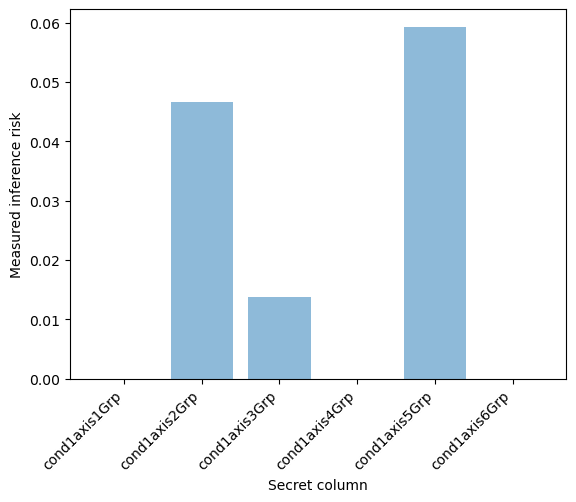

In [184]:
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

## Validate Synthetic Data

To validate the synthetising process, we  run a unsupervised model (clustering) on both the synthetic referal and real referal and compare the results. The clustering algithm used handles the mix of numerical and categorical feaztures in the dataset

### Build the synthetic referral dataset for clustering and classification

compute stay Length and referral length if needed

In [33]:
df_referrals_synthetic_eval = df_referrals_synthetic.copy()
df_stays_synthetic_eval = df_stays_synthetic.copy()
#df_patients_synthetic_eval = df_patients_synth.copy()

In [34]:
df_referrals_synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   referralID         5569 non-null   int64         
 1   referralStartDate  5569 non-null   datetime64[ns]
 2   referralLength     5569 non-null   int64         
 3   age                5569 non-null   int64         
 4   sex                5569 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 217.7 KB


<Axes: xlabel='ageGrp'>

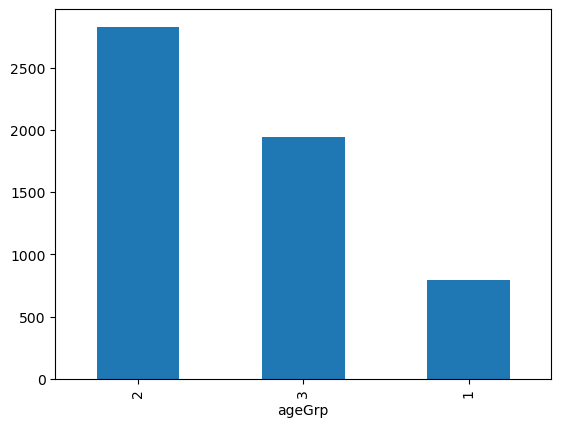

In [35]:
bins = [0,13,20,100 ]
labels = ['0-12','13-19', '20+']
df_referrals_synthetic_eval['ageGrpDesc'] = pd.cut(df_referrals_synthetic_eval.age, bins, labels = labels,include_lowest = True)
labels = ['1','2', '3']
df_referrals_synthetic_eval['ageGrp'] = pd.cut(df_referrals_synthetic_eval.age, bins, labels = labels,include_lowest = True)
df_referrals_synthetic_eval['ageGrp'].value_counts().plot(kind='bar')

In [36]:
df_referrals_synthetic_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   referralID         5569 non-null   int64         
 1   referralStartDate  5569 non-null   datetime64[ns]
 2   referralLength     5569 non-null   int64         
 3   age                5569 non-null   int64         
 4   sex                5569 non-null   int64         
 5   ageGrpDesc         5569 non-null   category      
 6   ageGrp             5569 non-null   category      
dtypes: category(2), datetime64[ns](1), int64(4)
memory usage: 228.8 KB


In [37]:
df =df_stays_synthetic_eval.groupby(['referralID']).agg({
#'kontaktTypeGrp_Direkte_pasientkontakt':'sum'
#,'kontaktTypeGrp_Indirekte_pasientkontakt':'sum'
'stayLength':'median' })
df.head()

,stayLength
referralID,
5569,0.0
5570,0.0
5571,0.0
5572,0.0
5573,720.0


In [38]:

              
                                         
                                         
                                        
df_referrals_synthetic_eval = pd.merge(df_referrals_synthetic_eval, df, how='left', left_on=['referralID'], right_on=['referralID'])
df_referrals_synthetic_eval.head()

,referralID,referralStartDate,referralLength,age,sex,ageGrpDesc,ageGrp,stayLength
0,5569,2002-12-30,45,21,1,20+,3,0.0
1,5570,2002-12-30,440,17,1,13-19,2,0.0
2,5571,2002-12-30,25,14,2,13-19,2,0.0
3,5572,2002-12-29,1003,17,1,13-19,2,0.0
4,5573,2002-12-30,273,24,1,20+,3,720.0


In [39]:
sorted_df = df_stays_synthetic_eval[['referralID','stayStartDate','cond1axis1Grp']].sort_values(by=['referralID','stayStartDate'], ascending=True)
g= sorted_df.groupby(['referralID'])

In [40]:

df = g.head(1)[['referralID','cond1axis1Grp']]
df_referrals_synthetic_eval = pd.merge(df_referrals_synthetic_eval, df, how='left',on=['referralID'])
df_referrals_synthetic_eval.rename({'cond1axis1Grp': 'cond1axis1GrpFirst'}, axis=1, inplace=True) 
df_referrals_synthetic_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          5569 non-null   int64         
 1   referralStartDate   5569 non-null   datetime64[ns]
 2   referralLength      5569 non-null   int64         
 3   age                 5569 non-null   int64         
 4   sex                 5569 non-null   int64         
 5   ageGrpDesc          5569 non-null   category      
 6   ageGrp              5569 non-null   category      
 7   stayLength          5569 non-null   float64       
 8   cond1axis1GrpFirst  5569 non-null   object        
dtypes: category(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 315.8+ KB


In [41]:
## First
#sorted_df = df_stays_synthetic_eval[['referralID','stayStartDate','cond1axis1Grp']].sort_values(by=['referralID','stayStartDate'], ascending=True)
#g= sorted_df.groupby(['referralID'])

#df = g.head(1)[['referralID','cond1axis1Grp']]

#df_referals_synthetic_eval = pd.merge(df_referrals_synthetic_eval, df, how='left',on=['referralID'])
#df_referrals_synthetic_eval.info()
#df_referrals_synthetic_eval.rename(columns={'cond1axis1Grp':'cond1axis1GrpFirst'}, inplace=True)
#df_referals_synthetic_eval.head()
#df_referrals_synthetic_eval.info()
#df_referals_synthetic_eval.head()
### Last
df = g.tail(1)[['referralID','cond1axis1Grp']]
df_referrals_synthetic_eval = pd.merge(df_referrals_synthetic_eval, df, how='left',on=['referralID'])
df_referrals_synthetic_eval.rename(columns={'cond1axis1Grp': 'cond1axis1GrpLast'}, inplace=True)
df_referrals_synthetic_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          5569 non-null   int64         
 1   referralStartDate   5569 non-null   datetime64[ns]
 2   referralLength      5569 non-null   int64         
 3   age                 5569 non-null   int64         
 4   sex                 5569 non-null   int64         
 5   ageGrpDesc          5569 non-null   category      
 6   ageGrp              5569 non-null   category      
 7   stayLength          5569 non-null   float64       
 8   cond1axis1GrpFirst  5569 non-null   object        
 9   cond1axis1GrpLast   5569 non-null   object        
dtypes: category(2), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 359.3+ KB


In [42]:
stays_groupby= df_stays_synthetic_eval.groupby('referralID', as_index=False)['stayID'].count()
stays_groupby.head()


,referralID,stayID
0,5569,2
1,5570,5
2,5571,31
3,5572,26
4,5573,6


In [43]:
df_referrals_synthetic_eval = pd.merge(df_referrals_synthetic_eval, stays_groupby, how='left', left_on=['referralID'], right_on=['referralID'])
df_referrals_synthetic_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          5569 non-null   int64         
 1   referralStartDate   5569 non-null   datetime64[ns]
 2   referralLength      5569 non-null   int64         
 3   age                 5569 non-null   int64         
 4   sex                 5569 non-null   int64         
 5   ageGrpDesc          5569 non-null   category      
 6   ageGrp              5569 non-null   category      
 7   stayLength          5569 non-null   float64       
 8   cond1axis1GrpFirst  5569 non-null   object        
 9   cond1axis1GrpLast   5569 non-null   object        
 10  stayID              5569 non-null   int64         
dtypes: category(2), datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 402.8+ KB


In [44]:
df_referrals_synthetic_eval.rename(columns = {'stayID':'numOfStays'}, inplace = True)

In [45]:
#df_referrals_synthetic_eval = pd.merge(df_referrals_synthetic_eval, df_patients_synthetic_eval,how='left', left_on=['patientNr'], right_on=['patientNr'] )
df_referrals_synthetic_eval.head()

,referralID,referralStartDate,referralLength,age,sex,ageGrpDesc,ageGrp,stayLength,cond1axis1GrpFirst,cond1axis1GrpLast,numOfStays
0,5569,2002-12-30,45,21,1,20+,3,0.0,R40-R46,F30-F39,2
1,5570,2002-12-30,440,17,1,13-19,2,0.0,R40-R46,R40-R46,5
2,5571,2002-12-30,25,14,2,13-19,2,0.0,andre,andre,31
3,5572,2002-12-29,1003,17,1,13-19,2,0.0,F90-F98,F90-F98,26
4,5573,2002-12-30,273,24,1,20+,3,720.0,1999,1999,6


#### Remove outliers

In [46]:
#https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles
cols = ['referralLength','numOfStays'] # one or more

Q1 = df_referrals_synthetic_eval[cols].quantile(0.25)
Q3 = df_referrals_synthetic_eval[cols].quantile(0.75)
IQR = Q3 - Q1

df_referrals_synthetic_eval = df_referrals_synthetic_eval[~((df_referrals_synthetic_eval[cols] < (Q1 - 1.5 * IQR)) |(df_referrals_synthetic_eval[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [47]:
df_referrals_synthetic_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4979 entries, 0 to 5568
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          4979 non-null   int64         
 1   referralStartDate   4979 non-null   datetime64[ns]
 2   referralLength      4979 non-null   int64         
 3   age                 4979 non-null   int64         
 4   sex                 4979 non-null   int64         
 5   ageGrpDesc          4979 non-null   category      
 6   ageGrp              4979 non-null   category      
 7   stayLength          4979 non-null   float64       
 8   cond1axis1GrpFirst  4979 non-null   object        
 9   cond1axis1GrpLast   4979 non-null   object        
 10  numOfStays          4979 non-null   int64         
dtypes: category(2), datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 399.0+ KB


In [48]:
features = [ 
      'referralLength', 
    'numOfStays',
         #  'episode_varighet',
            'sex', 
       #'tilst1akse1GrpFirst',
       #'cond1axis1GrpFirst'
          'cond1axis1GrpLast'
            # 'tilst1akse2GrpFirst',
      # 'tilst2akse1GrpLast', #'tilst1akse3GrpFirst', 
     
       #'tilst1akse4GrpFirst'
        #   'tilst3akse1GrpLast', 
            #'tilst1akse5GrpFirst',
     #  'tilst4akse1GrpLast', 
        #    'tilst1akse6GrpFirst', 
       #     'tilst5akse1GrpLast',
 
       # 'polUtforendeGrp_Annet_helsepersonell',
    #   'polUtforendeGrp_Fysioterapeut',
      # 'polUtforendeGrp_Klinisk ernaeringsfysiolog',
    #    'polUtforendeGrp_Lege',
      # 'polUtforendeGrp_Pedagog', 
#'polUtforendeGrp_Psykolog',
      # 'polUtforendeGrp_Sosionom', 
     # 'polUtforendeGrp_Sykepleie',
     # 'polUtforendeGrp_Vernepleier'
      ,'ageGrpDesc'
           ]

In [49]:
categorical_features = ['sex'
 #'tilst1akse1GrpFirst',
, 'cond1axis1GrpLast'
#, 'tilst2akse1GrpLast'
# ',tilst3akse1GrpLast',
# ,'tilst4akse1GrpLast',
# ,'tilst5akse1GrpLast'
# ,'tilst1akse6GrpFirst',

       ,'ageGrpDesc'
                       ]
nominal_features =['sex'
# 'tilst1akse1GrpFirst',
, 'cond1axis1GrpLast'
#, 'tilst2akse1GrpLast'
 #',tilst3akse1GrpLast',
 #',tilst4akse1GrpLast',
 #,'tilst5akse1GrpLast'
         ]


#ordinal_features = ['ageGrp']
numerical_features = [ 'referralLength','numOfStays'
     #   ,'episode_varighet'
    #    ,'polUtforendeGrp_Annet_helsepersonell',
    #   'polUtforendeGrp_Fysioterapeut',
      # 'polUtforendeGrp_Klinisk ernaeringsfysiolog',
    #    'polUtforendeGrp_Lege',
      # 'polUtforendeGrp_Pedagog', 
    #   'polUtforendeGrp_Psykolog',
    #   'polUtforendeGrp_Sosionom', 
     # 'polUtforendeGrp_Sykepleie',
     # 'polUtforendeGrp_Vernepleier'
                     ]
          
           

In [50]:
for c in categorical_features:
    df_referrals_synthetic_eval[c] = df_referrals_synthetic_eval[c].astype('object')
df_referrals_synthetic_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4979 entries, 0 to 5568
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          4979 non-null   int64         
 1   referralStartDate   4979 non-null   datetime64[ns]
 2   referralLength      4979 non-null   int64         
 3   age                 4979 non-null   int64         
 4   sex                 4979 non-null   object        
 5   ageGrpDesc          4979 non-null   object        
 6   ageGrp              4979 non-null   category      
 7   stayLength          4979 non-null   float64       
 8   cond1axis1GrpFirst  4979 non-null   object        
 9   cond1axis1GrpLast   4979 non-null   object        
 10  numOfStays          4979 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 432.9+ KB


<Axes: ylabel='cond1axis1GrpLast'>

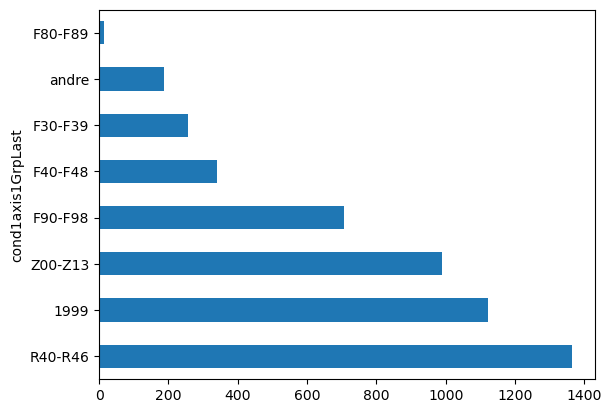

In [51]:
df_referrals_synthetic_eval.cond1axis1GrpLast.value_counts().plot(kind='barh')

referals with 'Z00-Z13','R40-R46 codesas the main Diagnosesi of the laset episode are  filtered out 

In [52]:
df_referrals_synth_cluster = df_referrals_synthetic_eval.copy()
df_referrals_synth_cluster= df_referrals_synth_cluster[features]
df_referrals_synth_cluster = df_referrals_synth_cluster.dropna()
df_referrals_synth_cluster = df_referrals_synth_cluster[~df_referrals_synth_cluster.cond1axis1GrpLast.isin(['Z00-Z13','R40-R46','1999'])]
#df_referrals_synth_cluster = df_referrals_synth_cluster[~df_referrals_synth_cluster['cond1axis1GrpFirst'].isin(['Z00-Z13','R40-R46'])]

df_referrals_synth_cluster= df_referrals_synth_cluster[features]
df_referrals_synth_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1503 entries, 0 to 5564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   referralLength     1503 non-null   int64 
 1   numOfStays         1503 non-null   int64 
 2   sex                1503 non-null   object
 3   cond1axis1GrpLast  1503 non-null   object
 4   ageGrpDesc         1503 non-null   object
dtypes: int64(2), object(3)
memory usage: 70.5+ KB


In [53]:
catColumnsPos = [df_referrals_synth_cluster.columns.get_loc(col) for col in categorical_features]
print('Categorical columns           : {}'.format(categorical_features))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['sex', 'cond1axis1GrpLast', 'ageGrpDesc']
Categorical columns position  : [2, 3, 4]


In [54]:

for c in numerical_features:
    pt = PowerTransformer()
    df_referrals_synth_cluster[c] =  pt.fit_transform(np.array(df_referrals_synth_cluster[c]).reshape(-1, 1))

In [55]:
df_referrals_synth_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1503 entries, 0 to 5564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   referralLength     1503 non-null   float64
 1   numOfStays         1503 non-null   float64
 2   sex                1503 non-null   object 
 3   cond1axis1GrpLast  1503 non-null   object 
 4   ageGrpDesc         1503 non-null   object 
dtypes: float64(2), object(3)
memory usage: 70.5+ KB


### Cluster the synthetic referals

In [56]:
#df_referrals_synth_c = df_referrals_synth_cluster.dropna()
dfMatrix =df_referrals_synth_cluster.to_numpy()

In [180]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 11):
   # try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Cao', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
   # except:
   #     break


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10


In [181]:
# inertia scores: confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
from kneed import KneeLocator
cost_knee_c3  = KneeLocator(
        range(1,11), 
        cost, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_inertia_b3 = cost_knee_c3 .elbow   
print("elbow at k =", f'{K_inertia_b3:.0f} clusters')

elbow at k = 4 clusters


Text(0, 0.5, 'cost function')

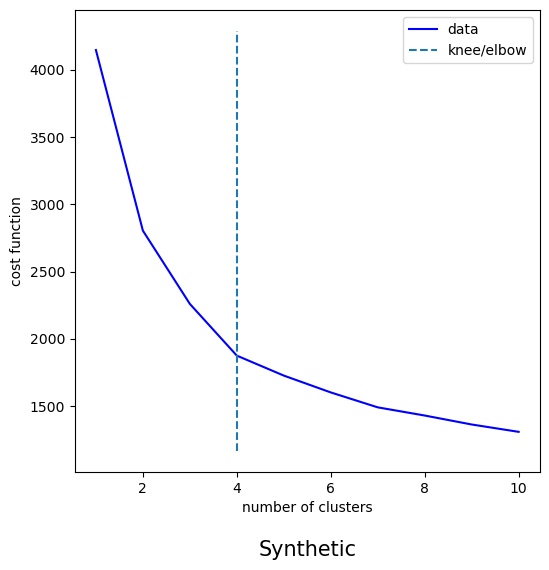

In [182]:
import matplotlib.pyplot as plt
cost_knee_c3.plot_knee()
plt.title("Synthetic", y=-0.2,fontsize = 15)
plt.xlabel('number of clusters', fontsize=10)
plt.xlabel('number of clusters', fontsize=10)
plt.ylabel('cost function', fontsize=10)


In [183]:
## perform clustering

In [184]:
# Fit the cluster
#kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
#kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

kproto = KPrototypes(n_clusters= 4, init='Cao', n_jobs = -1
, random_state = 0)
clusters = kproto.fit_predict(dfMatrix, categorical=catColumnsPos)

In [185]:
df_referrals_synthetic_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4979 entries, 0 to 5568
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          4979 non-null   int64         
 1   referralStartDate   4979 non-null   datetime64[ns]
 2   referralLength      4979 non-null   int64         
 3   age                 4979 non-null   int64         
 4   sex                 4979 non-null   object        
 5   ageGrpDesc          4979 non-null   object        
 6   ageGrp              4979 non-null   category      
 7   stayLength          4979 non-null   float64       
 8   cond1axis1GrpFirst  4979 non-null   object        
 9   cond1axis1GrpLast   4979 non-null   object        
 10  numOfStays          4979 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 432.9+ KB


In [186]:
df_synth = df_referrals_synthetic_eval.copy()
#df_synth= df_synth[features]
df_synth = df_synth.dropna()
df_synth = df_synth[~df_synth.cond1axis1GrpLast.isin(['Z00-Z13','R40-R46','1999'])]
df_synth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1503 entries, 0 to 5564
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          1503 non-null   int64         
 1   referralStartDate   1503 non-null   datetime64[ns]
 2   referralLength      1503 non-null   int64         
 3   age                 1503 non-null   int64         
 4   sex                 1503 non-null   object        
 5   ageGrpDesc          1503 non-null   object        
 6   ageGrp              1503 non-null   category      
 7   stayLength          1503 non-null   float64       
 8   cond1axis1GrpFirst  1503 non-null   object        
 9   cond1axis1GrpLast   1503 non-null   object        
 10  numOfStays          1503 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 130.8+ KB


In [187]:
df_synth.cond1axis1GrpLast.value_counts()

cond1axis1GrpLast
F90-F98    706
F40-F48    341
F30-F39    255
andre      187
F80-F89     14
Name: count, dtype: int64

In [188]:

df_synth= df_synth[features]

df_synth['cluster'] = clusters

In [189]:
df_synth['cluster'].value_counts()

cluster
2    402
3    387
0    361
1    353
Name: count, dtype: int64

In [190]:


def cluster_profile(df):
    dfc = df.groupby("cluster").agg({ 
        "sex": lambda x: x.value_counts().index[0],
        #  "alderGrp": lambda x: x.value_counts().index[0],
        "referralLength": "median",
         "numOfStays": "median",
     #   "episode_varighet": "median",
   
       
          "cond1axis1Grp_1": lambda x: x.value_counts().index[0],
         "cond1axis1Grp_2": lambda x: x.value_counts().index[1],
         "cond1axis1Grp_3": lambda x: x.value_counts().index[2],
       
       
  
        
     
     "ageGrpDesc": lambda x: x.value_counts().index[0]
      
                                    }).sort_values(by=["cluster"], ascending=True)

   # df[nominal_features+numerical_features+['cluster']].groupby(["cluster"]).agg(lambda x:x.value_counts().index[0])
    return dfc

In [191]:

df_synth['cond1axis1Grp_1']=df_synth['cond1axis1GrpLast']
df_synth['cond1axis1Grp_2']=df_synth['cond1axis1GrpLast']
df_synth['cond1axis1Grp_3']=df_synth['cond1axis1GrpLast']
cluster_profile(df_synth)

,sex,referralLength,numOfStays,cond1axis1Grp_1,cond1axis1Grp_2,cond1axis1Grp_3,ageGrpDesc
cluster,,,,,,,
0,2,128.0,3.0,F90-F98,F40-F48,F30-F39,13-19
1,1,622.0,3.0,F90-F98,F40-F48,F30-F39,20+
2,1,866.5,14.0,F90-F98,F40-F48,F30-F39,13-19
3,2,249.0,13.0,F90-F98,F40-F48,F30-F39,13-19


#### Visualise the clusters

Text(0.5, 0.01, 'Synthetic Data')

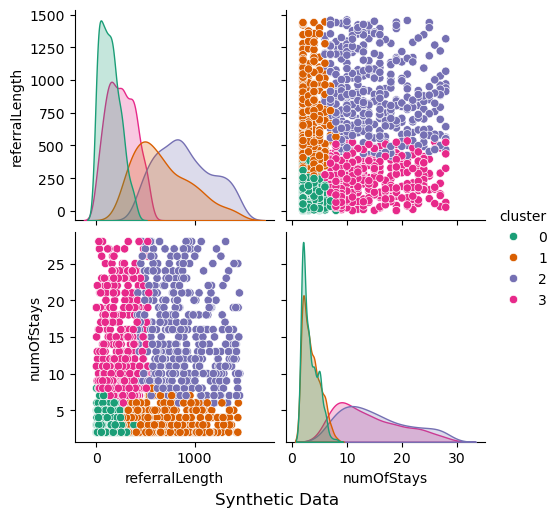

In [192]:
#Visualize K-Prototype clustering 
for col in ['sex',  'ageGrpDesc']:
    df_synth[col] = df_synth[col].astype('category')
g2 =sns.pairplot(df_synth,hue='cluster',palette='Dark2',diag_kind='kde',hue_order=[0,1,2,3])
#g2._legend.remove()
g2.fig.suptitle("Synthetic Data", y=0.01)
############### 1. SAVE PLOTS IN MEMORY TEMPORALLY
#g2.savefig('g2.png', dpi=300)
#plt.close(g2.fig)



## Classification evaluation

In [365]:
features =[
       'referralLength', 
       'numOfStays', 'cond1axis1GrpLast', 'sex', 'ageGrpDesc'
       ]
categorical_features=['cond1axis1GrpLast', 'sex', 'ageGrpDesc']

In [366]:
df_referrals_synthetic_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4979 entries, 0 to 5568
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          4979 non-null   int64         
 1   referralStartDate   4979 non-null   datetime64[ns]
 2   referralLength      4979 non-null   int64         
 3   age                 4979 non-null   int64         
 4   sex                 4979 non-null   object        
 5   ageGrpDesc          4979 non-null   object        
 6   ageGrp              4979 non-null   object        
 7   stayLength          4979 non-null   float64       
 8   cond1axis1GrpFirst  4979 non-null   object        
 9   cond1axis1GrpLast   4979 non-null   object        
 10  numOfStays          4979 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 466.8+ KB


In [367]:
# Setting the objects to category 
lgbm_synth_data = df_referrals_synthetic_eval.copy()

lgbm_synth_data = lgbm_synth_data[~lgbm_synth_data.cond1axis1GrpLast.isin(['Z00-Z13','R40-R46','1999'])]

lgbm_synth_data[categorical_features] = lgbm_synth_data[categorical_features].astype('category')
target_synth = lgbm_synth_data[ 'numOfStays']
lgbm_synth_data=lgbm_synth_data[features]   

In [368]:
lgbm_synth_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1503 entries, 0 to 5564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   referralLength     1503 non-null   int64   
 1   numOfStays         1503 non-null   int64   
 2   cond1axis1GrpLast  1503 non-null   category
 3   sex                1503 non-null   category
 4   ageGrpDesc         1503 non-null   category
dtypes: category(3), int64(2)
memory usage: 40.1 KB


In [369]:
#KMeans clusters
clf_kp = LGBMClassifier(feature_fraction =0.8)
cv_scores_km = cross_val_score(clf_kp, lgbm_synth_data, clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 1202, number of used features: 5
[LightGBM] [Info] Start training from score -1.428782
[LightGBM] [Info] Start training from score -1.449835
[LightGBM] [Info] Start training from score -1.317191
[LightGBM] [Info] Start training from score -1.355170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [370]:
clf_kp.fit(lgbm_synth_data,  target_synth)

#shap.summary_plot(shap_values_kp, X, plot_type="bar")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 5
[LightGBM] [Info] Start training from score -1.694818
[LightGBM] [Info] Start training from score -2.278266
[LightGBM] [Info] Start training from score -2.579020
[LightGBM] [Info] Start training from score -2.761341
[LightGBM] [Info] Start training from score -3.024759
[LightGBM] [Info] Start training from score -3.052539
[LightGBM] [Info] Start training from score -3.125564
[LightGBM] [Info] Start training from score -3.272167
[LightGBM] [Info] Start training f

LGBMClassifier(feature_fraction=0.8)

In [375]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

In [376]:
shap_values_kp

[array([[-6.44495515e-01,  1.27667121e+01, -3.40511737e-02,
          2.67133906e-03, -2.30063177e-02],
        [-4.34817317e-01, -2.86979502e+00, -3.30517734e-02,
         -3.94455130e-03,  3.88952730e-02],
        [-5.96451848e-01, -2.91054688e+00, -3.30517734e-02,
         -4.07790722e-03,  1.52974464e-02],
        ...,
        [ 3.10923759e-01,  1.27606944e+01,  1.40895707e-02,
          3.54845743e-02,  3.97437193e-03],
        [ 3.80934664e-01,  1.27532102e+01, -5.16361650e-03,
         -5.68086770e-03,  7.69594854e-03],
        [ 1.64205236e-01, -2.91040119e+00, -6.14090086e-03,
          3.59960269e-02, -8.74314958e-03]]),
 array([[-3.91128431e-01,  1.46212179e-01,  0.00000000e+00,
          1.84701592e-01, -1.12194753e-01],
        [-4.06855085e-01, -1.85229988e+00,  0.00000000e+00,
          2.06220759e-01,  8.36494640e-02],
        [-1.92394530e-01,  1.26261590e+01,  0.00000000e+00,
          2.39755983e-01,  1.06770603e-01],
        ...,
        [ 1.13472911e-01,  9.4905337

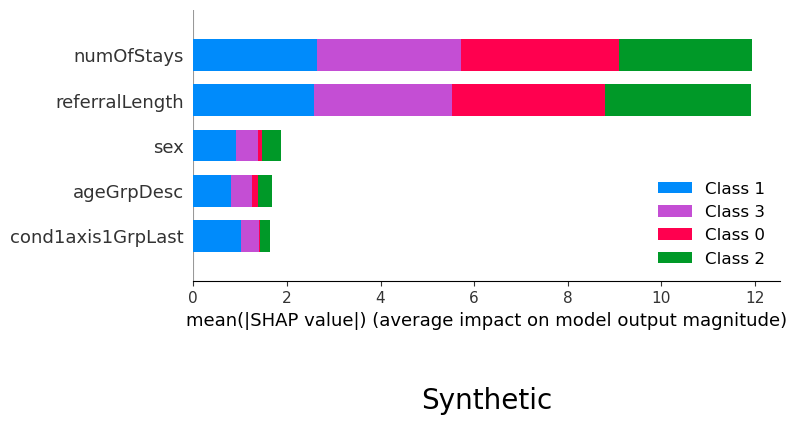

In [407]:
shap.summary_plot(shap_values_kp, lgbm_synth_data, plot_type="bar",show=False)
plt.title("Synthetic", y=-0.5,fontsize = 20)
#plt.legend('',frameon=False)
plt.show()

In [378]:
cluster_profile(df_synth)

,sex,referralLength,numOfStays,cond1axis1Grp_1,cond1axis1Grp_2,cond1axis1Grp_3,ageGrpDesc
cluster,,,,,,,
0,2,128.0,3.0,F90-F98,F40-F48,F30-F39,13-19
1,1,622.0,3.0,F90-F98,F40-F48,F30-F39,20+
2,1,866.5,14.0,F90-F98,F40-F48,F30-F39,13-19
3,2,249.0,13.0,F90-F98,F40-F48,F30-F39,13-19


## Cluster the Real Data

### Prepare Data for synthetising

In [149]:
features=['referralLength', 'numOfStays', 'cond1axis1GrpLast','sex', 'ageGrpDesc']

In [150]:
categorical_features=['sex','ageGrpDesc', 'cond1axis1GrpLast']

In [151]:
numerical_features =['referralLength', 'numOfStays']

In [152]:
df_referrals_real_eval= df_referrals_real[features]
#df_patients_eval= df_patients.copy()
df_referrals_real_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7730 entries, 0 to 7729
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   referralLength     7730 non-null   int64 
 1   numOfStays         7730 non-null   int64 
 2   cond1axis1GrpLast  7730 non-null   object
 3   sex                7730 non-null   int64 
 4   ageGrpDesc         7730 non-null   object
dtypes: int64(3), object(2)
memory usage: 302.1+ KB


### Remove outliers

In [153]:
#https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles
cols = ['referralLength','numOfStays'] # one or more

Q1 = df_referrals_real_eval[cols].quantile(0.25)
Q3 = df_referrals_real_eval[cols].quantile(0.75)
IQR = Q3 - Q1

df_referrals_real_eval = df_referrals_real_eval[~((df_referrals_real_eval[cols] < (Q1 - 1.5 * IQR)) |(df_referrals_real_eval[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
df_referrals_real_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6969 entries, 1 to 7729
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   referralLength     6969 non-null   int64 
 1   numOfStays         6969 non-null   int64 
 2   cond1axis1GrpLast  6969 non-null   object
 3   sex                6969 non-null   int64 
 4   ageGrpDesc         6969 non-null   object
dtypes: int64(3), object(2)
memory usage: 326.7+ KB


In [154]:
features

['referralLength', 'numOfStays', 'cond1axis1GrpLast', 'sex', 'ageGrpDesc']

In [155]:
df_real_cluster = df_referrals_real_eval.copy()
df_real_cluster= df_real_cluster[features]
df_real_cluster = df_real_cluster.dropna()
df_real_cluster = df_real_cluster[~df_real_cluster.cond1axis1GrpLast.isin(['Z00-Z13','R40-R46','1999'])]
df_real_cluster= df_real_cluster[features]
df_real_cluster.info()


    

<class 'pandas.core.frame.DataFrame'>
Index: 4261 entries, 1 to 7729
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   referralLength     4261 non-null   int64 
 1   numOfStays         4261 non-null   int64 
 2   cond1axis1GrpLast  4261 non-null   object
 3   sex                4261 non-null   int64 
 4   ageGrpDesc         4261 non-null   object
dtypes: int64(3), object(2)
memory usage: 199.7+ KB


In [156]:
catColumnsPos = [df_real_cluster
                 .columns.get_loc(col) for col in categorical_features]
print('Categorical columns           : {}'.format(categorical_features))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['sex', 'ageGrpDesc', 'cond1axis1GrpLast']
Categorical columns position  : [3, 4, 2]


In [157]:

for c in numerical_features:
    pt = PowerTransformer()     
    df_real_cluster[c] =  pt.fit_transform(np.array(df_real_cluster[c]).reshape(-1, 1))

In [158]:
dfMatrix = df_real_cluster.to_numpy()

In [159]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 11):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Cao', random_state = 55)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10


In [160]:
# inertia scores: confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
from kneed import KneeLocator
cost_knee_c3  = KneeLocator(
        range(1,11), 
        cost, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_inertia_b3 = cost_knee_c3 .elbow   
print("elbow at k =", f'{K_inertia_b3:.0f} clusters')

elbow at k = 4 clusters


Text(0, 0.5, 'cost function')

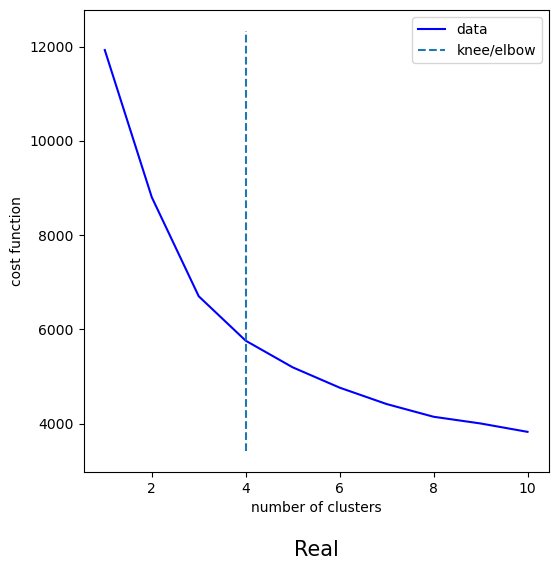

In [161]:

import matplotlib.pyplot as plt

cost_knee_c3.plot_knee()
plt.xlabel('number of clusters', fontsize=10)
plt.title("Real", y=-0.2,fontsize = 15)
plt.ylabel('cost function', fontsize=10)

In [162]:
# Fit the cluster
#kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
#kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

kproto = KPrototypes(n_clusters= 4
                     , init='Cao', n_jobs = -1
, random_state = 0)
clusters = kproto.fit_predict(dfMatrix, categorical=catColumnsPos)

In [163]:
df_real = df_referrals_real_eval.copy()
df_real= df_real[features]
df_real = df_real.dropna()
df_real = df_real[~df_real.cond1axis1GrpLast.isin(['Z00-Z13','R40-R46','1999'])]
df_real= df_real[features]
df_real['cluster'] = clusters
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4261 entries, 1 to 7729
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   referralLength     4261 non-null   int64 
 1   numOfStays         4261 non-null   int64 
 2   cond1axis1GrpLast  4261 non-null   object
 3   sex                4261 non-null   int64 
 4   ageGrpDesc         4261 non-null   object
 5   cluster            4261 non-null   uint16
dtypes: int64(3), object(2), uint16(1)
memory usage: 208.1+ KB


In [164]:
df_real['cluster'].value_counts()

cluster
1    1250
0    1060
3    1038
2     913
Name: count, dtype: int64

In [167]:

df_real['cond1axis1Grp_1']=df_real['cond1axis1GrpLast']
df_real['cond1axis1Grp_2']=df_real['cond1axis1GrpLast']
df_real['cond1axis1Grp_3']=df_real['cond1axis1GrpLast']
cluster_profile(df_real)

,sex,referralLength,numOfStays,cond1axis1Grp_1,cond1axis1Grp_2,cond1axis1Grp_3,ageGrpDesc
cluster,,,,,,,
0,1,744.0,3.0,F90-F98,F40-F48,F80-F89,13-19
1,2,285.5,13.0,F40-F48,andre,F90-F98,20+
2,1,191.0,3.0,F90-F98,andre,F40-F48,13-19
3,1,709.0,13.0,F90-F98,F40-F48,F80-F89,13-19


#### Visualise clusters

In [168]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4261 entries, 1 to 7729
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   referralLength     4261 non-null   int64 
 1   numOfStays         4261 non-null   int64 
 2   cond1axis1GrpLast  4261 non-null   object
 3   sex                4261 non-null   int64 
 4   ageGrpDesc         4261 non-null   object
 5   cluster            4261 non-null   uint16
 6   cond1axis1Grp_1    4261 non-null   object
 7   cond1axis1Grp_2    4261 non-null   object
 8   cond1axis1Grp_3    4261 non-null   object
dtypes: int64(3), object(5), uint16(1)
memory usage: 307.9+ KB


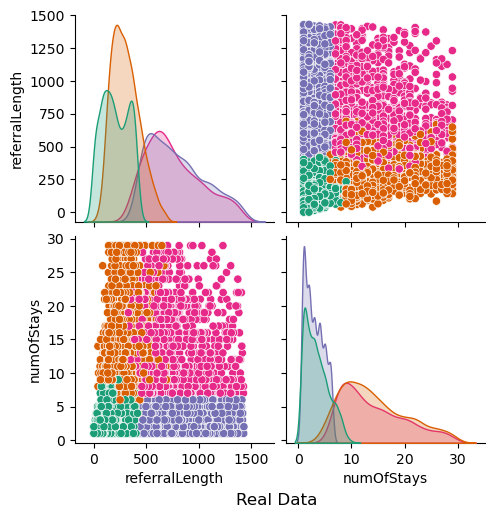

In [169]:
#Visualize K-Prototype clustering 
for col in ['sex', 'cond1axis1GrpLast', 'ageGrpDesc']:
    df_real[col] = df_real[col].astype('category')
g1 =sns.pairplot(df_real,hue='cluster',palette='Dark2',diag_kind='kde',hue_order=[2,1,0,3])
g1.fig.suptitle("Real Data", y=0.01)
#plt.legend([],[], frameon=False)
g1._legend.remove()
#g1.savefig('g1.png', dpi=300)
plt.show()


## Cluster features

In [170]:
features =[
       'referralLength', 
       'numOfStays', 'cond1axis1GrpLast', 'sex', 'ageGrpDesc'
       ]

In [171]:
categorical_features=['cond1axis1GrpLast', 'sex', 'ageGrpDesc']

In [172]:
# Setting the objects to category 
lgbm_data = df_real[features]

    
lgbm_data[categorical_features] = lgbm_data[categorical_features].astype('category')
lgbm_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4261 entries, 1 to 7729
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   referralLength     4261 non-null   int64   
 1   numOfStays         4261 non-null   int64   
 2   cond1axis1GrpLast  4261 non-null   category
 3   sex                4261 non-null   category
 4   ageGrpDesc         4261 non-null   category
dtypes: category(3), int64(2)
memory usage: 112.8 KB


In [173]:
#KMeans clusters
clf_kp = LGBMClassifier(feature_fraction =0.8)
cv_scores_km = cross_val_score(clf_kp, lgbm_data, clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 3408, number of used features: 5
[LightGBM] [Info] Start training from score -1.391000
[LightGBM] [Info] Start training from score -1.226126
[LightGBM] [Info] Start training from score -1.540836
[LightGBM] [Info] Start training from score -1.412455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 3409, number of used features: 5
[LightGBM] [Info] Start training from score -1.391294
[LightGBM] [Info] Start training from score -1.226419
[LightGBM] [Info] Start training from score -1.539761
[LightGBM] [Info] Start training from score -1.412749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8, c

In [174]:
clf_kp.fit(lgbm_data,  clusters)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 4261, number of used features: 5
[LightGBM] [Info] Start training from score -1.391235
[LightGBM] [Info] Start training from score -1.226360
[LightGBM] [Info] Start training from score -1.540523
[LightGBM] [Info] Start training from score -1.412208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(feature_fraction=0.8)

In [175]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

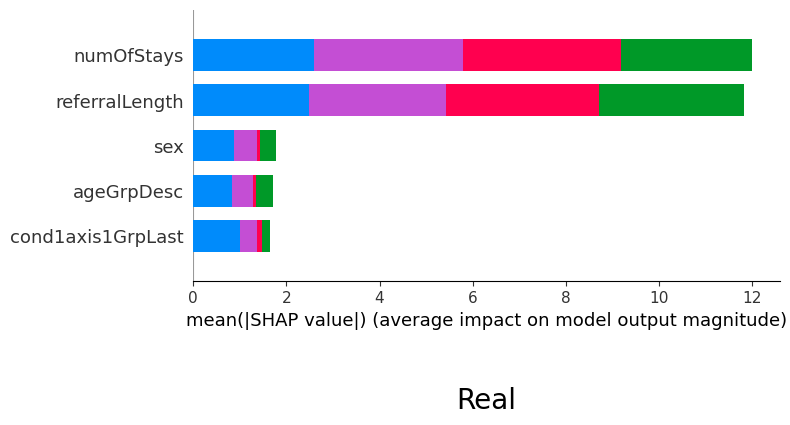

In [176]:
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar",show=False)
plt.title("Real", y=-0.5,fontsize = 20)
plt.legend('',frameon=False)
plt.show()

## compare clusters

In [177]:
cluster_profile(df_real)

,sex,referralLength,numOfStays,cond1axis1Grp_1,cond1axis1Grp_2,cond1axis1Grp_3,ageGrpDesc
cluster,,,,,,,
0,1,744.0,3.0,F90-F98,F40-F48,F80-F89,13-19
1,2,285.5,13.0,F40-F48,andre,F90-F98,20+
2,1,191.0,3.0,F90-F98,andre,F40-F48,13-19
3,1,709.0,13.0,F90-F98,F40-F48,F80-F89,13-19


In [193]:
cluster_profile(df_synth)

,sex,referralLength,numOfStays,cond1axis1Grp_1,cond1axis1Grp_2,cond1axis1Grp_3,ageGrpDesc
cluster,,,,,,,
0,2,128.0,3.0,F90-F98,F40-F48,F30-F39,13-19
1,1,622.0,3.0,F90-F98,F40-F48,F30-F39,20+
2,1,866.5,14.0,F90-F98,F40-F48,F30-F39,13-19
3,2,249.0,13.0,F90-F98,F40-F48,F30-F39,13-19


### Evaluate with a classfication

## Classification Real Data

In [57]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder


In [58]:
features =[
        
        'cond1axis1GrpFirst', 'sex', 'ageGrpDesc'
       ]

In [59]:
categorical_features =[
  
      'cond1axis1GrpFirst', 'sex', 'ageGrpDesc']

In [60]:

df_referrals_real_eval= df_referrals_real.copy()
#df_patients_eval= df_patients.copy()
df_referrals_real_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7730 entries, 0 to 7729
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   referralID          7730 non-null   int64         
 1   patientNr           7730 non-null   int64         
 2   referralStartDate   7730 non-null   datetime64[ns]
 3   referralEndDate     7730 non-null   datetime64[ns]
 4   referralLength      7730 non-null   int64         
 5   numOfStays          7730 non-null   int64         
 6   cond1axis1GrpLast   7730 non-null   object        
 7   cond1axis1GrpFirst  7730 non-null   object        
 8   ageGrp              7730 non-null   int64         
 9   ageGrpDesc          7730 non-null   object        
 10  sex                 7730 non-null   int64         
 11  age                 7730 non-null   int64         
dtypes: datetime64[ns](2), int64(7), object(3)
memory usage: 724.8+ KB


In [61]:
#define the scorer
from sklearn.metrics import mean_squared_log_error,  make_scorer,mean_squared_error
myscorer=make_scorer(mean_squared_error, greater_is_better=False, squared=False)



In [62]:
# Setting the objects to category 
lgbm_real_data = df_referrals_real_eval.copy()
lgbm_real_data = lgbm_real_data[~lgbm_real_data.cond1axis1GrpFirst.isin(['Z00-Z13','R40-R46','1999'])]
    
lgbm_real_data[categorical_features] = lgbm_real_data[categorical_features].astype('category')
target_real = lgbm_real_data[ 'numOfStays']

In [63]:

X_cat=lgbm_real_data[categorical_features]

#fit encoder
enc = OneHotEncoder()
enc.fit(X_cat)

#transform categorical features
X_encoded = enc.transform(X_cat).toarray()

#create feature matrix
feature_names = X_cat.columns
new_feature_names = enc.get_feature_names_out(feature_names)

X = pd.DataFrame(X_encoded, columns= new_feature_names)

In [64]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': 'rmse',
    'min_data_in_leaf': 3,
}
reg_kp = LGBMRegressor (**hyper_params
   
    )
scores = cross_val_score(reg_kp, X, target_real, cv=3,scoring=myscorer)
# first convert to positive and then sqrt.
print("Average cross-validation RMSE score:{:.2f}".format(scores.mean()*-1))

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] S

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 3198, number of used features: 3
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] St

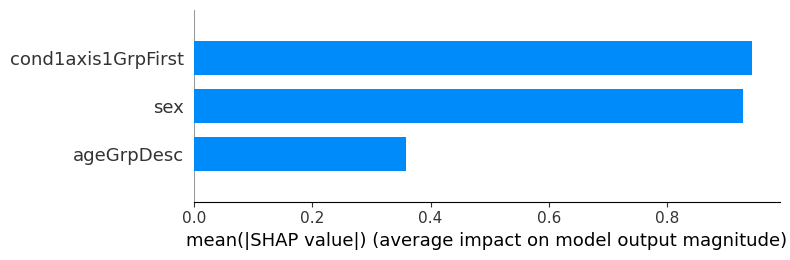

In [65]:
reg_kp.fit(lgbm_real_data[features],  target_real)
explainer_kp = shap.TreeExplainer(reg_kp)
shap_values_real = explainer_kp(lgbm_real_data[features])
shap.summary_plot(shap_values_real, lgbm_real_data[features], plot_type="bar")

get number of unique categories for each feature 

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 3198, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] S

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


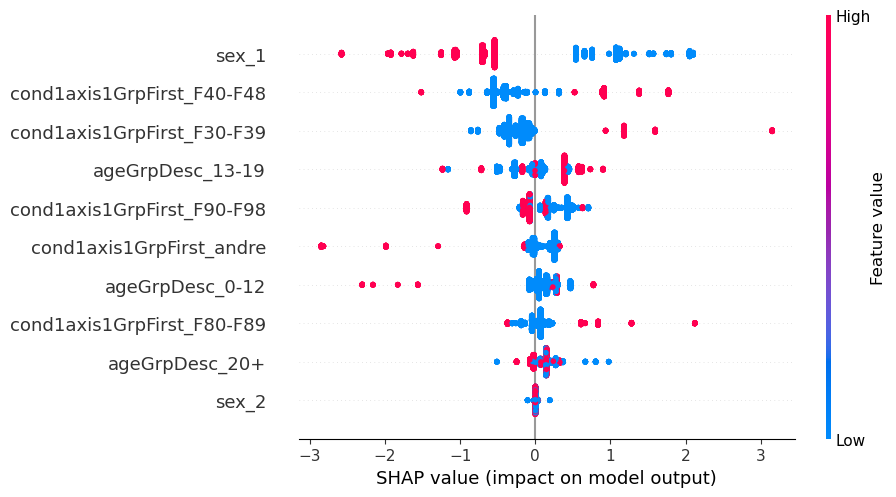

In [66]:
reg_kp.fit(X,  target_real)
explainer_kp = shap.TreeExplainer(reg_kp)
shap_values_real = explainer_kp(X)

shap.plots.beeswarm(shap_values_real, max_display=20)

In [67]:
shap_values_real.data.shape

(3198, 10)

In [68]:
shap_values_real

.values =
array([[-0.26360046, -0.43172207,  0.06676653, ..., -0.07956285,
        -0.26869738,  0.14820393],
       [-0.34726616, -0.54996419,  0.07062513, ...,  0.05004006,
         0.38777752,  0.14109555],
       [-0.34726616, -0.54996419,  0.07062513, ...,  0.05004006,
         0.38777752,  0.14109555],
       ...,
       [-0.76519233, -0.88002353, -0.13635626, ...,  0.16120971,
        -0.71895146,  0.36712715],
       [-0.41341464, -0.56343849, -0.0435554 , ...,  0.01785607,
        -0.00420171,  0.27039024],
       [-0.16447297,  0.91541371, -0.04493091, ...,  0.27422821,
         0.07741043, -0.01623201]])

.base_values =
array([8.980732, 8.980732, 8.980732, ..., 8.980732, 8.980732, 8.980732])

.data =
array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [69]:
#get number of unique categories for each feature 
n_categories = []
for feat in feature_names[:-1]:
    n = X_cat[feat].nunique()
    n_categories.append(n)
n_categories

[5, 2]

In [70]:
np.array(X_cat)

array([['F90-F98', 1, '20+'],
       ['F90-F98', 1, '13-19'],
       ['F90-F98', 1, '13-19'],
       ...,
       ['andre', 2, '13-19'],
       ['F90-F98', 2, '13-19'],
       ['F40-F48', 2, '20+']], dtype=object)

In [71]:
import math

new_shap_values = []
for values in shap_values_real.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    #print(values_split)
    #sum values within each list
    values_sum = [math.fsum(l) for l in values_split]
    
    new_shap_values.append(values_sum)
np.shape(new_shap_values)

(3198, 3)

In [72]:
new_shap_values

[[-0.599558221837635, -0.7099787917326981, -0.20005629454947485],
 [-0.6517682385870134, -0.5333550988695394, 0.5789131312271576],
 [-0.6517682385870134, -0.5333550988695394, 0.5789131312271576],
 [-0.6517682385870134, -0.5333550988695394, 0.5789131312271576],
 [-0.6517682385870134, -0.5333550988695394, 0.5789131312271576],
 [-0.6517682385870134, -0.5333550988695394, 0.5789131312271576],
 [-0.6517682385870134, -0.5333550988695394, 0.5789131312271576],
 [-0.976040525409735, 0.5388624438791038, 0.2840446049921517],
 [-0.976040525409735, 0.5388624438791038, 0.2840446049921517],
 [-0.6517682385870134, -0.5333550988695394, 0.5789131312271576],
 [-1.4984806726328037, 0.7558664505638621, -0.02933443572216772],
 [-0.6517682385870134, -0.5333550988695394, 0.5789131312271576],
 [-3.4574656313288537, -1.9082511155257864, 0.16880618115016874],
 [-0.599558221837635, -0.7099787917326981, -0.20005629454947485],
 [-0.976040525409735, 0.5388624438791038, 0.2840446049921517],
 [-0.6517682385870134, -0.5

In [73]:

#replace shap values
shap_values_real.values = np.array(new_shap_values)

#replace data with categorical feature values 
new_data = np.array(X_cat)
shap_values_real.data = np.array(new_data)

#update feature names
shap_values_real.feature_names = list(X_cat.columns)

In [74]:
new_data = np.array(X_cat)
shap_values_real

.values =
array([[-0.59955822, -0.70997879, -0.20005629],
       [-0.65176824, -0.5333551 ,  0.57891313],
       [-0.65176824, -0.5333551 ,  0.57891313],
       ...,
       [-1.67108558,  2.0990567 , -0.1906146 ],
       [-0.97604053,  0.53886244,  0.2840446 ],
       [ 1.10090271,  1.0743187 ,  0.33540664]])

.base_values =
array([8.980732, 8.980732, 8.980732, ..., 8.980732, 8.980732, 8.980732])

.data =
array([['F90-F98', 1, '20+'],
       ['F90-F98', 1, '13-19'],
       ['F90-F98', 1, '13-19'],
       ...,
       ['andre', 2, '13-19'],
       ['F90-F98', 2, '13-19'],
       ['F40-F48', 2, '20+']], dtype=object)

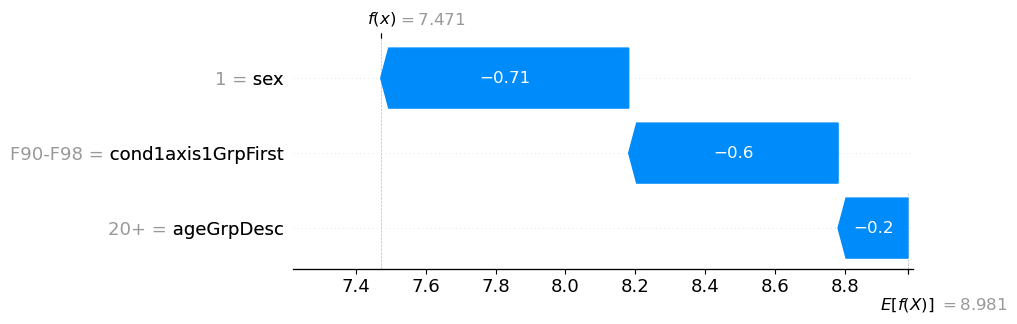

In [75]:

# waterfall plot for first observation
shap.plots.waterfall(shap_values_real[0])

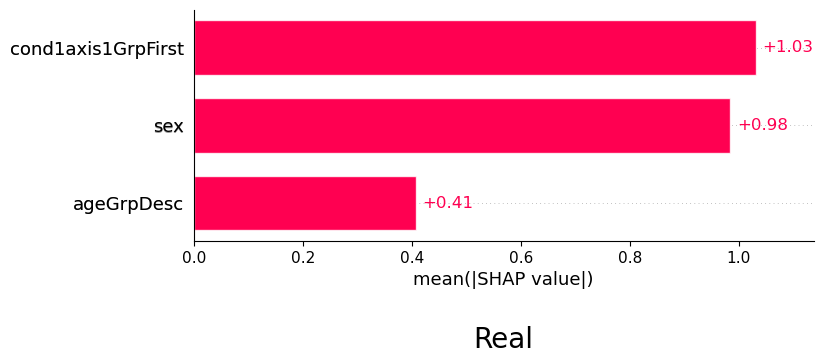

In [76]:
#Mean SHAP
shap.plots.bar(shap_values_real, show=False)
plt.title("Real", y=-0.5,fontsize = 20)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


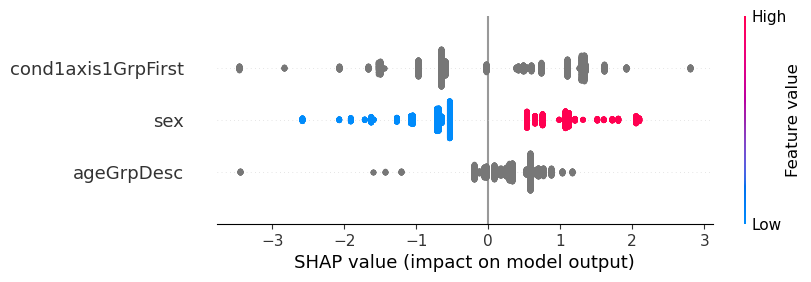

In [77]:
shap.plots.beeswarm(shap_values_real)

Text(0.5, 0, 'Real')

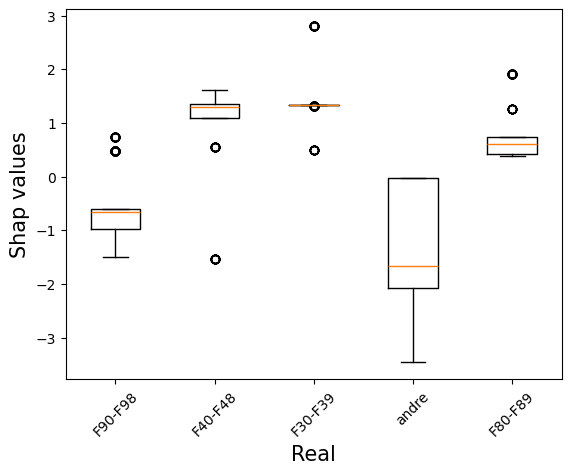

In [78]:
icd10_values = shap_values_real[:,"cond1axis1GrpFirst"].values
icd10_data = shap_values_real[:,"cond1axis1GrpFirst"].data
icd10_categories = list(set(icd10_data))
#print(age_categories)
icd10_categories = ['F90-F98','F40-F48', 'F30-F39',  'andre', 'F80-F89']
icd10_groups_real = []
for o in icd10_categories:
    relevant_values = icd10_values[icd10_data == o]
 
    icd10_groups_real.append(relevant_values)


labels = icd10_categories
#labels= [ageGrp_labels[u] for u in ageGrp_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))


plt.boxplot(icd10_groups_real,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)  

#plt.boxplot(ageGrp_groups,labels=labels)
plt.xticks(rotation=45)
plt.ylabel('Shap values',size=15)
plt.xlabel('Real',size=15)

Text(0.5, 0, 'Real')

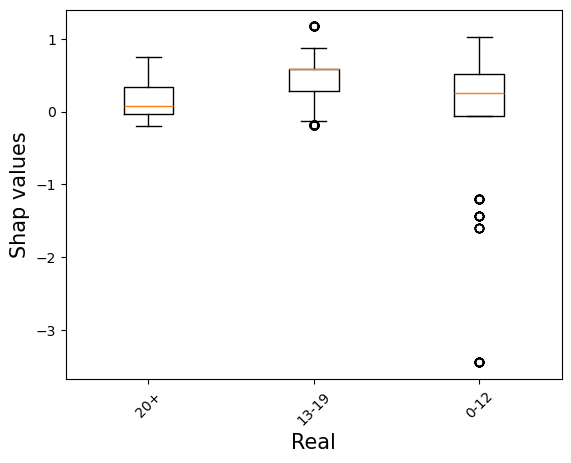

In [79]:
age_values = shap_values_real[:,"ageGrpDesc"].values
age_data = shap_values_real[:,"ageGrpDesc"].data
age_categories = list(set(age_data))
#print(age_categories)
#age_categories = ['0-12','13-19','20+']
age_groups = []
for o in age_categories:
    relevant_values = age_values[age_data == o]
 
    age_groups.append(relevant_values)


labels = age_categories
#labels= [ageGrp_labels[u] for u in ageGrp_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)

plt.boxplot(age_groups,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)  

#plt.boxplot(ageGrp_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Real',size=15)


Text(0.5, 0, 'Real')

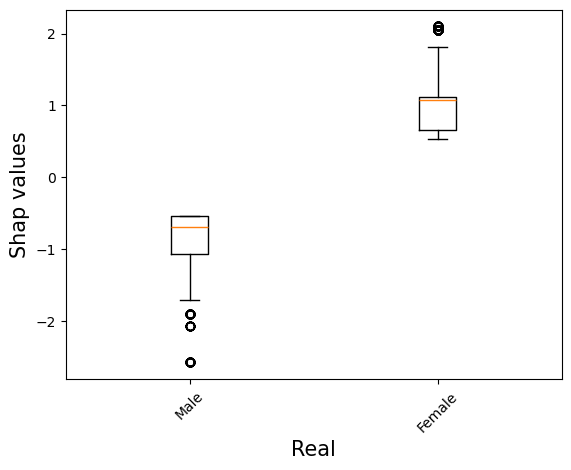

In [80]:
values = shap_values_real[:,"sex"].values
data = shap_values_real[:,"sex"].data
Kjonn_categories = list(set(data))
#print(age_categories)
#categories = ['1','2']
groups = []
for o in Kjonn_categories:
    relevant_values = values[data == o]
 
    groups.append(relevant_values)

#replace categories with labels
Kjonn_labels = {2:'Female',
                1:'Male'
            




              }

#labels = Kjonn_categories
labels= [Kjonn_labels[u] for u in Kjonn_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)

plt.boxplot(groups,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)  

#plt.boxplot(ageGrp_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Real',size=15)

## Classification synth Data

In [82]:
es =[
  
      'cond1axis1GrpFirst', 'sex', 'ageGrpDesc']
categofeaturrical_features =[
  
      'cond1axis1GrpFirst', 'sex', 'ageGrpDesc']

In [83]:
# Setting the objects to category 
lgbm_synth_data = df_referrals_synthetic_eval.copy()
lgbm_synth_data = lgbm_synth_data[~lgbm_synth_data.cond1axis1GrpFirst.isin(['Z00-Z13','R40-R46','1999'])]
    
lgbm_synth_data[categorical_features] = lgbm_synth_data[categorical_features].astype('category')
target_synth = lgbm_synth_data[ 'numOfStays']

In [84]:
X_cat = lgbm_synth_data.drop('numOfStays', axis=1)
X_cat=X_cat[features]

#fit encoder
enc = OneHotEncoder()
enc.fit(X_cat)

#transform categorical features
X_encoded = enc.transform(X_cat).toarray()

#create feature matrix
feature_names = X_cat.columns
new_feature_names = enc.get_feature_names_out(feature_names)

X = pd.DataFrame(X_encoded, columns= new_feature_names)

In [85]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': 'rmse',
    'min_data_in_leaf': 3,
}
reg_kp = LGBMRegressor (**hyper_params
   
    )
scores = cross_val_score(reg_kp, X, target_synth, cv=3,scoring=myscorer)
# first convert to positive and then sqrt.
print("Average cross-validation RMSE score:{:.2f}".format(scores.mean()*-1))

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 992, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] St

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 1488, number of us

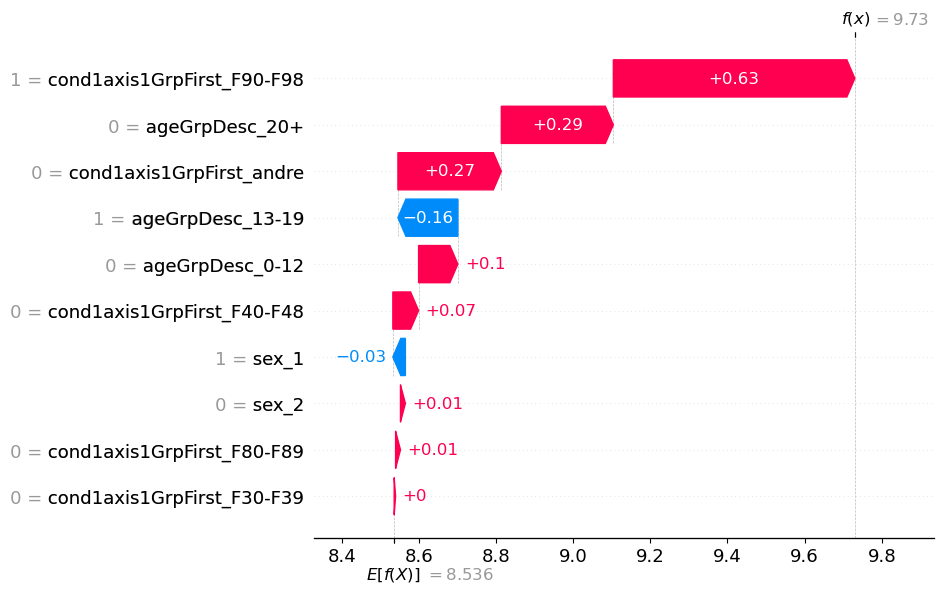

In [86]:
reg_kp.fit(X,  target_synth)
explainer_kp = shap.Explainer(reg_kp)
shap_values = explainer_kp(X)
shap.plots.waterfall(shap_values[0])

## SHAP for categorical features

Let's start by exploring the shap_values object. We print the object in the code below. You can see in the output below that is made of 3 components. We have the SHAP values (values) for each of the predictions. data gives the values for the binary features. Each prediction will also have the same base value (base_values). This is the average predicted log odds.

In [87]:

print(shap_values)

.values =
array([[ 0.00372956,  0.06672181,  0.01263192, ...,  0.101792  ,
        -0.15532172,  0.29035169],
       [ 0.11320094,  0.28165976, -0.0164571 , ...,  0.19556114,
         0.10372686,  0.30465545],
       [-0.02610302, -0.57465071, -0.00879299, ...,  0.18942889,
         0.53406659, -0.15101353],
       ...,
       [-0.35078124,  0.18207801, -0.01421179, ...,  0.21501809,
         0.52381898,  0.15480752],
       [ 0.15861488,  0.21407507, -0.00129488, ...,  0.11900685,
        -0.14702785,  0.04959518],
       [ 0.15861488,  0.21407507, -0.00129488, ...,  0.11900685,
        -0.14702785,  0.04959518]])

.base_values =
array([8.53608425, 8.53608425, 8.53608425, ..., 8.53608425, 8.53608425,
       8.53608425])

.data =
array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])


We can take a closer look at the SHAP values for the first prediction by printing them below. There are 10 values. One for each binary variable. The SHAP values are in the same order as the X feature matrix. Remember, the first categorical feature, cap-shape, had 6 categories. This means the first 6 SHAP values correspond to the binary features from this feature. The next 4 correspond to the cap-surface features and so on.

In [88]:
X.shape

(1488, 10)

In [89]:
shap_values.values.shape

(1488, 10)

We want to add the SHAP values for each categorical feature together. To do this we start by creating the n_categories array. This contains the number of unique categories for each categorical variable. The first number in the array will be 5 for Diagnosis  then 4 for sex and so on…



In [90]:
#get number of unique categories for each feature 
n_categories = []
for feat in feature_names[:-1]:
    n = X_cat[feat].nunique()
    n_categories.append(n)
n_categories

[5, 2]

We use n_categories to split the SHAP value arrays (line 5). We end up with a list of sublists. We then sum the values within each of these sublists (line 8). By doing this we go from 10 SHAP values to 3 SHAP values. We do this for every observation in the shap_values object (line 2). For each iteration, we add the summed shap values to the new_shap_values array (line 10).

In [91]:
import math

new_shap_values = []
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    #print(values_split)
    #sum values within each list
    values_sum = [math.fsum(l) for l in values_split]
    
    new_shap_values.append(values_sum)
np.shape(new_shap_values)

(1488, 3)

Now, all we need to do is replace the original SHAP values with the new values (line 2). We also replace the binary feature data with the category letters from the original categorical features (lines 5–6). Lastly, we replace the binary feature names with the original feature names (line 9). It is important to pass these new values as arrays and lists respectfully. These are the data types used by the shap_values object.

In [92]:

#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
new_data = np.array(X_cat)
shap_values.data = np.array(new_data)

#update feature names
shap_values.feature_names = list(X_cat.columns)

The updated shap_values object can be used just like the original object. In the code below we plot the waterfall for the first observation. You will notice this code is exactly the same as before.

You can see the output in Figure 4. We now have 22 SHAP values. You can also see the feature values on the left have been replaced with the category labels. We discussed the odor feature before. You can now clearly see the overall contribution of this feature. It has decreased the log odds by 0.29.

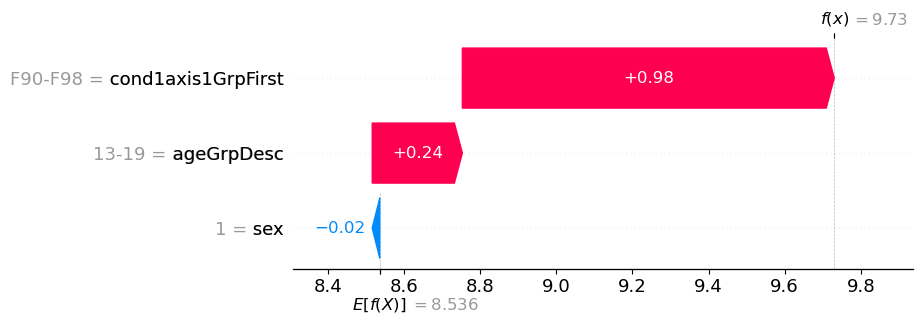

In [93]:

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In the above plot, we have odor = a. This tells us the mushroom had an “almond” scent. We should avoid interpreting the plot as “the almond scent has decreased the log odds”. We have summed multiple SHAP values together. Hence, we should interpret it as “the almond scent and lack of other scents has decreased the log odds”. For example, looking at the first waterfall plot the lack of a “foul” odor (odor_f = 0) has also decreased the log odds.

Before we move on to aggregations of these new SHAP values, it is worth discussing some theory. The reason we are able to do this with SHAP values is because of their additive property. That is the average prediction (E[f(x)]) plus all of the SHAP values equal the actual prediction (f(x)). By adding some SHAP values together we do not interfere with this property. This is why f(x) = -2.444 is the same in both Figure 3 and Figure 4.

## Mean SHAP

Like with the waterfall plot, we can use the SHAP aggregations just like with the original SHAP values. For example, we use the mean SHAP plot in the code below. Looking at Figure 5, we can use this plot to highlight important categorical features. For example, we can see that odor tends to have large positive/ negative SHAP values.

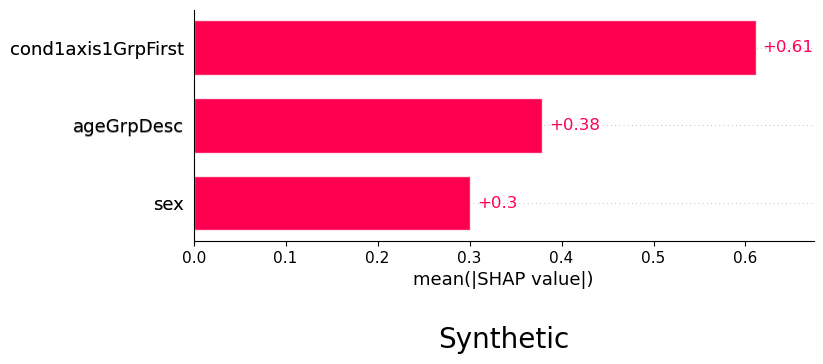

In [94]:
#Mean SHAP
shap.plots.bar(shap_values, show=False)
plt.title("Synthetic", y=-0.5,fontsize = 20)
plt.show()

## Beeswarm

Another common aggregation is the beeswarm plot. For continuous variables, this plot is useful as it can help explain the nature of the relationships. We can see how SHAP values are associated with the feature values. However, for the categorical features, we have replaced the feature values with labels. As a result, in Figure 6, you can see the SHAP values are all given the same colour. We need to create our own plots to understand the nature of these relationships.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


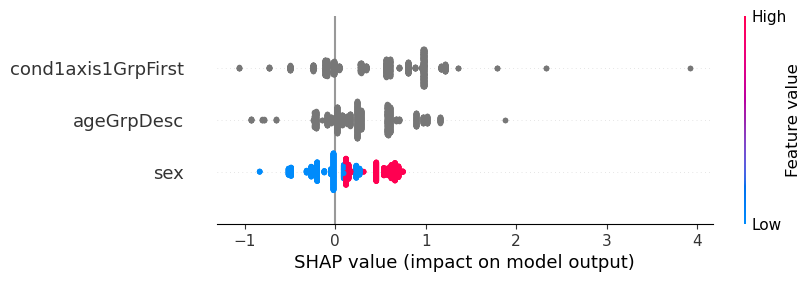

In [95]:
shap.plots.beeswarm(shap_values)

# SHAP Boxplot

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

One way we can do this is by using boxplots of the SHAP values. In Figure 7, you can see one for the odor feature. Here we have grouped the SHAP values for the odor feature base on the odor category. You can see that a foul smell leads to higher SHAP values. These mushrooms are more likely to be poisonous. Please do not eat any bad-smelling mushrooms! Similarly, mushrooms with no smell are more likely to be edible. A single orange line means all the SHAP values for those mushrooms were the same.

We create this boxplot using the code below. We start by getting the odor SHAP values (line 2). Remember these are the update values. For each prediction, there will be only one SHAP value for the odor feature. We also get the odor category labels (line 3). We split the SHAP values based on these labels (lines 6-11). Lately, we use these values to plot a boxplot for each of the odor categories (lines 27–32). To make the chart easier to interpret, we have also replaced the letter with the full category names (lines 14–24).

Text(0.5, 0, 'Synthetic')

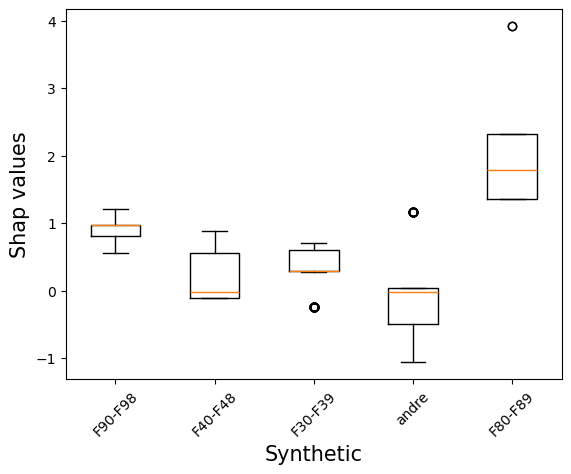

In [97]:
age_values = shap_values[:,"cond1axis1GrpFirst"].values
age_data = shap_values[:,"cond1axis1GrpFirst"].data
age_categories = list(set(age_data))
#print(age_categories)
age_categories = ['F90-F98','F40-F48', 'F30-F39',  'andre', 'F80-F89']
icd10_groups_synth = []
for o in age_categories:
    relevant_values = age_values[age_data == o]
 
    icd10_groups_synth.append(relevant_values)


labels = age_categories
#labels= [ageGrp_labels[u] for u in ageGrp_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))


plt.boxplot(icd10_groups_synth,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)  

#plt.boxplot(ageGrp_groups,labels=labels)
plt.xticks(rotation=45)
plt.ylabel('Shap values',size=15)
plt.xlabel('Synthetic',size=15)

Text(0.5, 0, 'Synthetic')

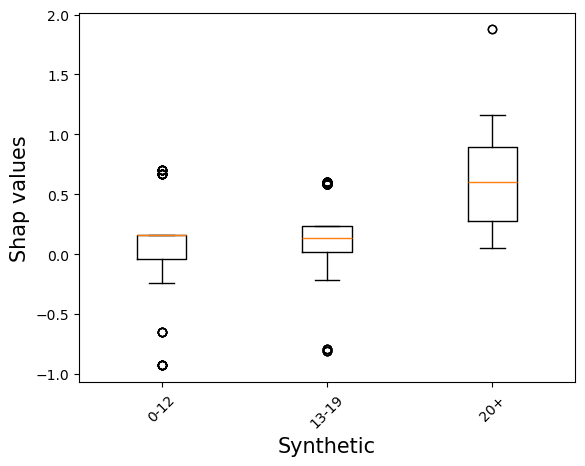

In [98]:
age_values = shap_values[:,"ageGrpDesc"].values
age_data = shap_values[:,"ageGrpDesc"].data
age_categories = list(set(age_data))
#print(age_categories)
age_categories = ['0-12','13-19','20+']
age_groups = []
for o in age_categories:
    relevant_values = age_values[age_data == o]
 
    age_groups.append(relevant_values)


labels = age_categories
#labels= [ageGrp_labels[u] for u in ageGrp_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)

plt.boxplot(age_groups,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)  

#plt.boxplot(ageGrp_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Synthetic',size=15)

Text(0.5, 0, 'Synthetic')

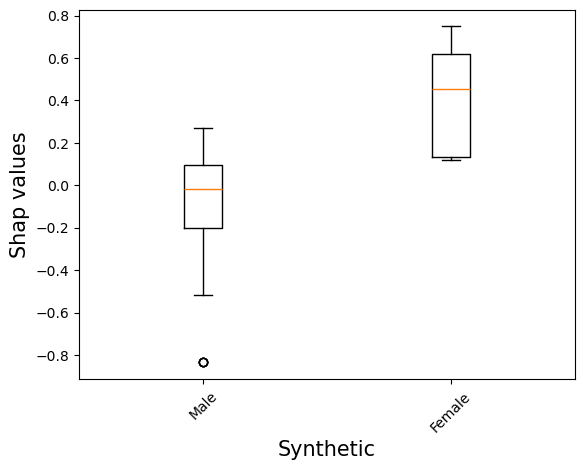

In [99]:
values = shap_values[:,"sex"].values
data = shap_values[:,"sex"].data
Kjonn_categories = list(set(data))
#print(age_categories)
#categories = ['1','2']
groups = []
for o in Kjonn_categories:
    relevant_values = values[data == o]
 
    groups.append(relevant_values)

#replace categories with labels
Kjonn_labels = {2:'Female',
                1:'Male'
            




              }

#labels = Kjonn_categories
labels= [Kjonn_labels[u] for u in Kjonn_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)

plt.boxplot(groups,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)  

#plt.boxplot(ageGrp_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Synthetic',size=15)

In practice, it is likely that only a handful of your features will be categorical. You will need to update the above process to only sum the categorical ones. You could also come up with your own way of visualising the relationships of these features. If you come up with another way I’d love to hear about it in the comments.

I’d also be interested to understand how feature dependencies will affect this analysis. By definition, the transformed binary features will be correlated. This can impact the SHAP value calculation. We are using TreeSHAP to estimate the SHAP values. My understanding is that these are not impacted by dependencies as much as KernelSHAP. I’m interested to hear your thoughts in the comments.

### Classify Real data with synthetic model

In [100]:
reg_kp.fit(lgbm_synth_data[features], target_synth)
expected_y  = target_real
predicted_y = reg_kp.predict(lgbm_real_data[features])

print(mean_squared_error(expected_y, predicted_y,squared=False))

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 3
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] St

### Classify synthetic data with Real model

In [101]:
reg_kp.fit(lgbm_real_data[features], target_real)
expected_y  = target_synth
predicted_y = reg_kp.predict(lgbm_synth_data[features])

print(mean_squared_error(expected_y, predicted_y,squared=False))

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 3198, number of us